# PyTorch

## Datos-ejemplo-mio

In [4]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 939 kB 38.2 MB/s 
     |████████████████████████████████| 251 kB 64.7 MB/s 


In [ ]:
pip install "monai-weekly[gdown, nibabel, tqdm, ignite]"

In [5]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_dicts = [
    {"image": '/content/gdrive/MyDrive/niftis/T1c.nii.gz', "label": '/content/gdrive/MyDrive/niftis/Segmentation.nii.gz'}
    # con la máscara del brats
    #{"image": '/content/gdrive/MyDrive/niftis/T1c.nii.gz', "label": '/content/BRATS_001.nii.gz'}
    #{"image": image_name, "label": label_name}
   # {"image": '/content/gdrive/MyDrive/niftis/T1c.nii.gz', "label": '/content/0_seg.nii.gz'}
    #for image_name, label_name in zip(train_images, train_labels)
]
# train_files, test_files = data_dicts[:-9], data_dicts[-9:]
test_files = data_dicts

In [ ]:
print(test_files)

[{'image': '/content/gdrive/MyDrive/niftis/T1c.nii.gz', 'label': '/content/0_seg.nii.gz'}]


In [ ]:
batch_size = 2
epochs = 600
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

test_transforms = Compose([
  LoadImaged(keys=["image", "label"]),
  EnsureChannelFirstd(keys=["image", "label"]),
  Spacingd(keys=["image", "label"], pixdim=(
      1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
  Orientationd(keys=["image", "label"], axcodes="RAS"),
  ScaleIntensityRanged(
      keys=["image"], a_min=-57, a_max=164,
      b_min=0.0, b_max=1.0, clip=True,
  ),
  CropForegroundd(keys=["image", "label"], source_key="image"),
  EnsureTyped(keys=["image", "label"]),
])

test_dataset = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=2)

Loading dataset: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


image shape: torch.Size([129, 153, 97]), label shape: torch.Size([129, 153, 97])


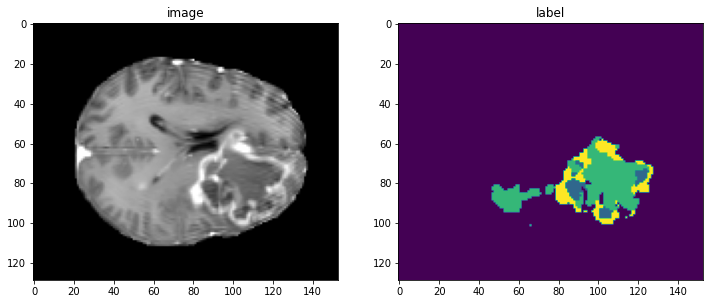

In [ ]:
# OPCIONAL --> Echamos un vistazo a una imagen y cómo es su segmentación 
check_dataset = Dataset(data=test_files, transform=test_transforms)
check_loader = DataLoader(check_dataset, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}") # 129 de alto, 153 de ancho, 97 de profundidad (capas)
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, int(image.shape[2]/2)], cmap="gray") # cogemos la mitad del nifti, la capa del medio, la shape[2]/2
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, int(label.shape[2]/2)])
plt.show()

image shape: torch.Size([129, 153, 97]), label shape: torch.Size([129, 153, 97])


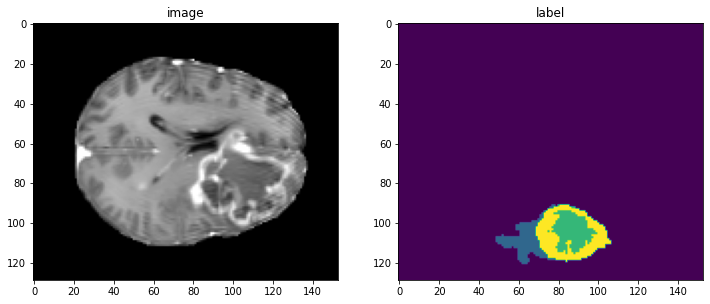

In [ ]:
# DATOS DEL BRATS
# OPCIONAL --> Echamos un vistazo a una imagen y cómo es su segmentación 
check_dataset = Dataset(data=test_files, transform=test_transforms)
check_loader = DataLoader(check_dataset, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}") # 129 de alto, 153 de ancho, 97 de profundidad (capas)
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, int(image.shape[2]/2)], cmap="gray") # cogemos la mitad del nifti, la capa del medio, la shape[2]/2
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 30])
plt.show()

image shape: torch.Size([129, 153, 97]), label shape: torch.Size([129, 153, 97])


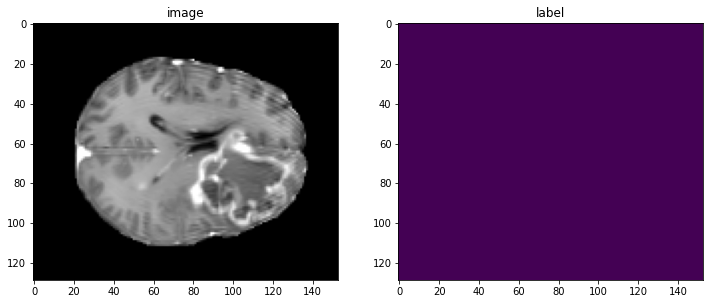

In [ ]:
# DATOS Generados por mi
# OPCIONAL --> Echamos un vistazo a una imagen y cómo es su segmentación 
check_dataset = Dataset(data=test_files, transform=test_transforms)
check_loader = DataLoader(check_dataset, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}") # 129 de alto, 153 de ancho, 97 de profundidad (capas)
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, int(image.shape[2]/2)], cmap="gray") # cogemos la mitad del nifti, la capa del medio, la shape[2]/2
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 96])
plt.show()

## Datos Brats

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly"

In [7]:
import os
import tempfile
import numpy as np
from monai.apps import DecathlonDataset
from monai.utils import first
from monai.data import DataLoader, decollate_batch
import matplotlib.pyplot as plt
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    # AsDiscreted,
    Compose,
    # Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    SaveImage,
)
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
import torch
import torch.nn as nn
from monai.networks.blocks.convolutions import Convolution
from monai.networks.layers import Norm

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmppq6mokwt


In [8]:
from google.colab import drive
drive.mount('/content/gdrive')
root_dir = '/content/gdrive/MyDrive'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(np.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                np.logical_or(
                    np.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

In [ ]:
# Enfoque multiclass. Añadimos una dimensión a las labels (la de channels) para que coincidan con las de las imágenes
class Multiclass(MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = [d[key]]
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

In [ ]:
# Delete 1 of the input channels
# 0 Flair, 1 T1, 2 T1C, 3 T2
class deleteT1(MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = np.delete(d[key],1,0) # Eliminamos el canal 1 de la dimensión 0, aka, T1
            d[key] = result.astype(np.float32)
        return d

In [ ]:
train_transform = Compose([
  # load 4 Nifti images and stack them together
  LoadImaged(keys=["image", "label"]),
  EnsureChannelFirstd(keys="image"),
  #ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
  Multiclass(keys="label"),
  deleteT1(keys='image'),
  Orientationd(keys=["image", "label"], axcodes="RAS"),
  Spacingd(
    keys=["image", "label"],
    pixdim=(1.0, 1.0, 1.0),
    mode=("bilinear", "nearest"),
  ),
  RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False), # cambiar roi?
  RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
  RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
  RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
  NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
  RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
  RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
  EnsureTyped(keys=["image", "label"]),
  Patched(keys=["image", "label"]),
])

val_transform = Compose([
  LoadImaged(keys=["image", "label"]),
  EnsureChannelFirstd(keys="image"),
  #ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
  Multiclass(keys="label"),
  deleteT1(keys='image'),
  Orientationd(keys=["image", "label"], axcodes="RAS"),
  Spacingd(
    keys=["image", "label"],
    pixdim=(1.0, 1.0, 1.0),
    mode=("bilinear", "nearest"),
  ),
  NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
  EnsureTyped(keys=["image", "label"]),
  Patched(keys=["image", "label"]),
])

In [ ]:
val_ds[0].keys()

dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict', 'image_transforms', 'label_transforms', 'patches'])

In [ ]:
# here we don't cache any data in case out of memory issue
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=False,
    cache_rate=0.0,
    #num_workers=4,
    num_workers=1,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1) # original 4 workers
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    #num_workers=4,
    num_workers=1,
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1) # original 4 workers

In [ ]:
train_ds.__getitem__(0).keys()

dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict', 'image_transforms', 'label_transforms', 'patches'])

image shape: torch.Size([4, 240, 240, 155])


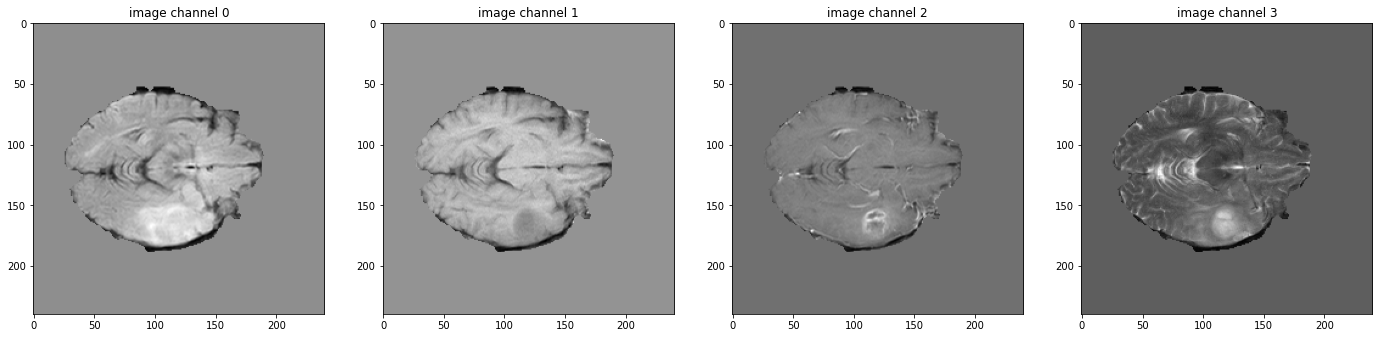

label shape: torch.Size([3, 240, 240, 155])


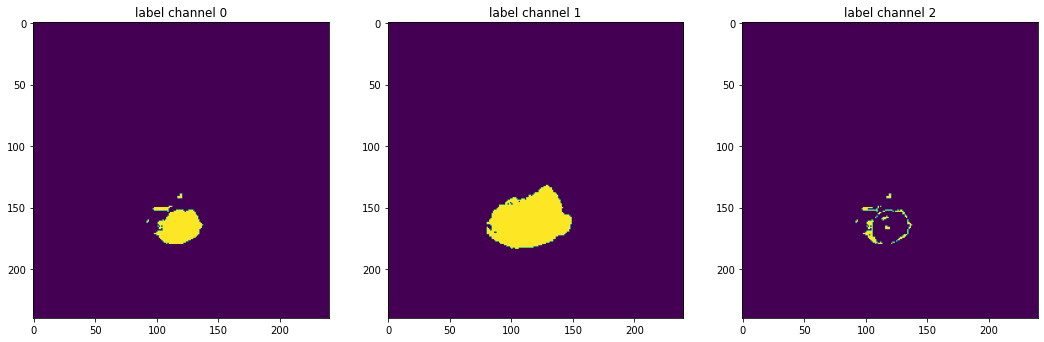

In [ ]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
val_data_example = val_ds[2]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, 60].detach().cpu())
plt.show()

/usr/local/lib/python3.7/dist-packages/monai/transforms/spatial/array.py:535: UserWarning: axcodes ('RAS') length is smaller than the number of input spatial dimensions D=2.
Orientation: input spatial shape is (240, 155), num. channels is 240,please make sure the input is in the channel-first format.
  f"axcodes ('{self.axcodes}') length is smaller than the number of input spatial dimensions D={sr}.\n"


image shape: torch.Size([4, 240, 240, 155])


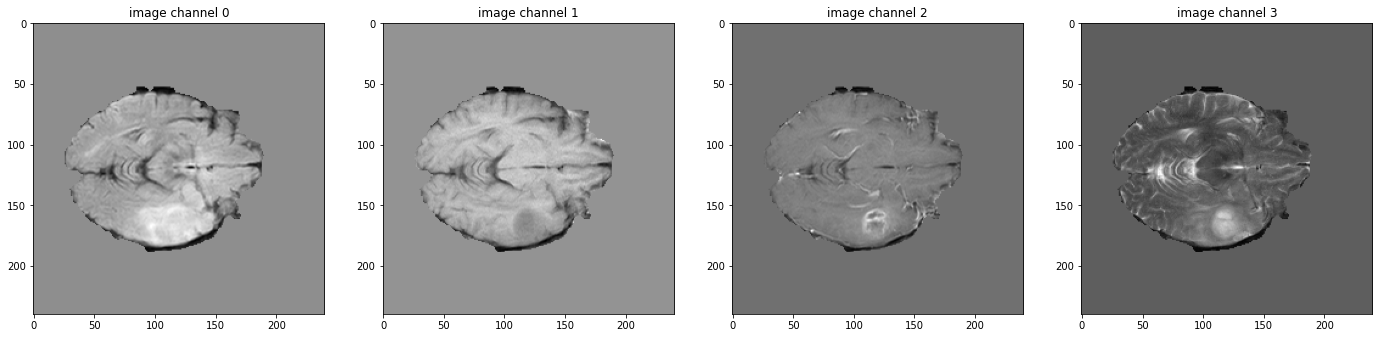

label shape: torch.Size([240, 240, 155])


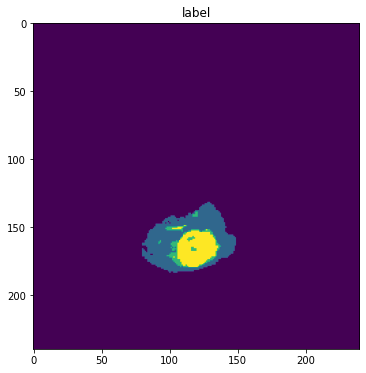

In [ ]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
# Label SIN Aplicar ConvertToMultiChannelBasedOnBratsClassesd
val_data_example = val_ds[2]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
plt.title("label")
plt.imshow(val_data_example["label"][:, :, 60].detach().cpu())
plt.show()

In [ ]:
def toMultiChannel(data):
  # entra 1 canal, salen 3
  result = []
  # merge label 2 and label 3 to construct TC
  result.append(np.logical_or(data == 2, data == 3))
  # merge labels 1, 2 and 3 to construct WT
  result.append(
    np.logical_or(np.logical_or(data == 2, data == 3), data == 1)
  )
  # label 2 is ET
  result.append(data == 2)
  resultado = np.stack(result, axis=0).astype(np.float32)
  return resultado

def toMonoChannel(data):
  a = data[1] # TC, 2 y 3
  b = data[0]*3 # WT, 1, 2 y 3
  c = data[2]*2 # ET, 2
  aux = np.where(b != 0, b, a)
  result = np.where(c != 0, c, aux)
  return result

No aplicamos ConvertToMultiChannelBasedOnBratsClassesd en transforms iniciales para ver la máscara de 3 clases en 1 canal


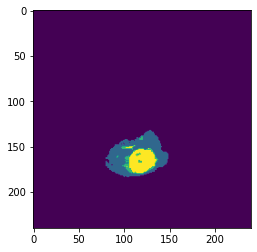

Aplicamos ConvertToMultiChannelBasedOnBratsClassesd ahora
label shape: (3, 240, 240, 155)


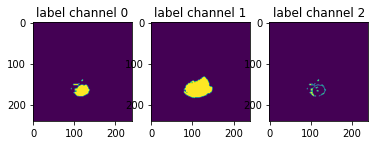

toMultichannel manual (creado por mí)
label shape: (3, 240, 240, 155)


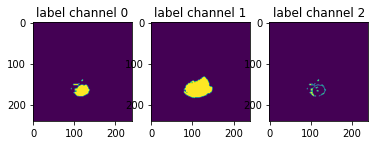

toMonochannel manual (creado por mí)
label shape: (240, 240, 155)


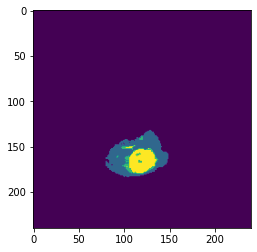

In [ ]:
# label sin aplicar ConvertToMultiChannelBasedOnBratsClassesd lo convertimos a 3 canales manualmente
prueva = ConvertToMultiChannelBasedOnBratsClassesd(keys="label")
dato = val_data_example
print('No aplicamos ConvertToMultiChannelBasedOnBratsClassesd en transforms iniciales para ver la máscara de 3 clases en 1 canal')
plt.imshow(dato["label"][:, :, 60].detach().cpu())
plt.show()
dato2 = prueva(dato) 
print('Aplicamos ConvertToMultiChannelBasedOnBratsClassesd ahora')
print(f"label shape: {dato2['label'].shape}")
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(torch.tensor(dato2["label"])[i, :, :, 60].detach().cpu())
plt.show()
print('toMultichannel manual (creado por mí)')
tensor = toMultiChannel(dato['label'])
print(f"label shape: {tensor.shape}")
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(torch.tensor(tensor[i, :, :, 60]).detach().cpu())
plt.show()
mascarafinal = toMonoChannel(dato2['label'])
print('toMonochannel manual (creado por mí)')
print(f"label shape: {mascarafinal.shape}")
plt.imshow(torch.tensor(mascarafinal)[:, :, 60].detach().cpu())
plt.show()

máscara original brats


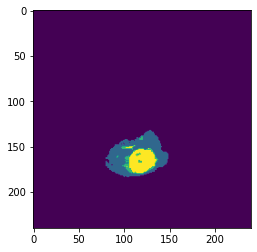

máscara creada por mí brats


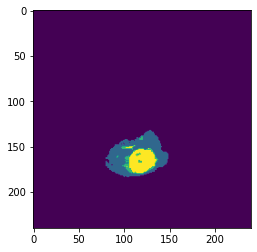

In [ ]:
print('máscara original brats')
plt.imshow(dato["label"][:, :, 60].detach().cpu())
plt.show()
print('máscara creada por mí brats')
plt.imshow(torch.tensor(mascarafinal)[:, :, 60].detach().cpu())
plt.show()

In [ ]:
# Guardar la máscara como NifTi
import nibabel as nb

ni_img = nb.Nifti1Image(mascarafinal, affine=np.eye(4))
nb.save(ni_img, "dicom_volume_image.nii.gz")

In [ ]:
# NO se ha aplicado ConvertToMultiChannelBasedOnBratsClassesd. Aplicaremos manualmente para comprobar que las funciones creadas son correctas
transformacion = ConvertToMultiChannelBasedOnBratsClassesd(keys="label")
for muestra in val_ds:
  # Comprobar que la máscara que he creado a partir de los 3 canales, se corresponde con la original 
  label_original_1canal = muestra['label']
  label_original_3canales = transformacion(muestra)['label']
  label_mio_3canales = toMultiChannel(label_original_1canal)
  label_mio_1canal = toMonoChannel(label_original_3canales)
  if (not np.array_equal(label_original_1canal, label_mio_1canal) or (not np.array_equal(label_original_3canales, label_mio_3canales))):
    print('Hay un error')
    break


/usr/local/lib/python3.7/dist-packages/monai/transforms/spatial/array.py:535: UserWarning: axcodes ('RAS') length is smaller than the number of input spatial dimensions D=2.
Orientation: input spatial shape is (240, 155), num. channels is 240,please make sure the input is in the channel-first format.
  f"axcodes ('{self.axcodes}') length is smaller than the number of input spatial dimensions D={sr}.\n"


## Parámetros

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 300
#batch_size = 2 # en el preoprocesado de datos se usa

## Modelo

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly"

In [10]:
from monai.networks.layers import Norm
from monai.networks.blocks.convolutions import Convolution

import torch
import torch.nn as nn

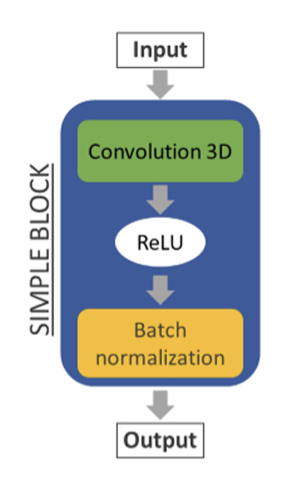

In [11]:
def simple_block(inc, out, kernel):
  block = Convolution(
      spatial_dims = 3, # Convolución 3D
      in_channels = inc,
      out_channels = out,
      kernel_size = kernel,
      norm = Norm.BATCH,
      act = 'ReLU',
      adn_ordering = 'AND' # Orden de las operaciones (no usamos dropout)
  )
  return block

def shortcut(inc, out):
  block = Convolution(
      spatial_dims = 3, # Convolución 3D
      in_channels = inc,
      out_channels = out,
      kernel_size = 1,
      norm = Norm.BATCH,
      act = None,
      adn_ordering = 'AND' # Orden de las operaciones (no usamos dropout)
  )
  return block

def downsampling_block(inc, out):
  block = Convolution(
      spatial_dims = 3, # Convolución 3D
      in_channels = inc,
      out_channels = out,
      strides = 2,
      kernel_size = 3,
      norm = Norm.BATCH,
      act = 'ReLU',
      adn_ordering = 'AND' # Orden de las operaciones
  )
  return block

def upsampling_block(inc, out):
  block = Convolution(
      spatial_dims = 3, # Convolución 3D
      in_channels = inc,
      out_channels = out,
      strides = 2,
      kernel_size = 3,
      norm = Norm.BATCH,
      act = 'ReLU',
      adn_ordering = 'AND', # Orden de las operaciones
      is_transposed = True
  )
  return block

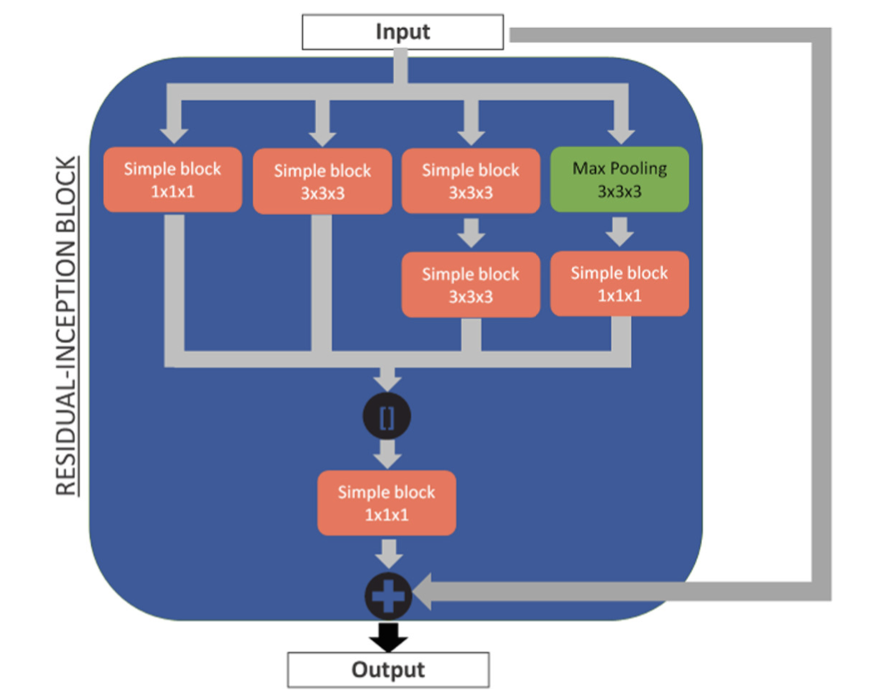

In [12]:
class residual_inception_block(nn.Module):
    def __init__(self, inc, out): # nº filtros entrada (capa anterior) y salida (actual)
        super(residual_inception_block, self).__init__()
        self.residual = nn.Identity()
        self.branch1x1x1 = simple_block(inc,out,1)
        self.branch3x3x3 = simple_block(inc,out,3)
        self.branch3x3x3double_1 = simple_block(inc,out,3)
        self.branch3x3x3double_2 = simple_block(out,out,3)
        self.branchpool_1 = nn.MaxPool3d(kernel_size=3, stride=1, padding=1) # padding para que la salida del mismo tamaño
        self.branchpool_2 = simple_block(inc,out,1)
        self.finalblock = simple_block(4*out,out,1) # al concatenar, la entrada es 4*nºfiltros, ya que hay 4 ramas
    
    def forward(self, x):
        residual = self.residual(x)
      # ramas de una capa
        branch1x1x1 = self.branch1x1x1(x)
        branch3x3x3 = self.branch3x3x3(x)
      # ramas de dos capas
        branch3x3x3double_1 = self.branch3x3x3double_1(x)
        branch3x3x3double_1 = self.branch3x3x3double_2(branch3x3x3double_1)
        branchpool_1 = self.branchpool_1(x)
        branchpool_1 = self.branchpool_2(branchpool_1)
      # Tras las ramas
        x = torch.cat([branch1x1x1, branch3x3x3, branch3x3x3double_1, branchpool_1], 1)
        x = self.finalblock(x)
        x = x + residual
        return x

# Este bloque para cuando el nº de filtros de entrada no coincide con el de salida, y hace falta modificar el residual
class residual_inception_block_shortcut(nn.Module):
    def __init__(self, inc, out): # nº filtros entrada (capa anterior) y salida (actual)
        super(residual_inception_block_shortcut, self).__init__()
        self.residual = nn.Identity()
        self.branch1x1x1 = simple_block(inc,out,1)
        self.branch3x3x3 = simple_block(inc,out,3)
        self.branch3x3x3double_1 = simple_block(inc,out,3)
        self.branch3x3x3double_2 = simple_block(out,out,3)
        self.branchpool_1 = nn.MaxPool3d(kernel_size=3, stride=1, padding=1) # padding para que la salida del mismo tamaño
        self.branchpool_2 = simple_block(inc,out,1)
        self.finalblock = simple_block(4*out,out,1) # al concatenar, la entrada es 4*nºfiltros, ya que hay 4 ramas
        self.shortcut = shortcut(inc, out) # Para que la entrada residual tenga el tamaño de la salida

    def forward(self, x):
        residual = self.residual(x)
      # ramas de una capa
        branch1x1x1 = self.branch1x1x1(x)
        branch3x3x3 = self.branch3x3x3(x)
      # ramas de dos capas
        branch3x3x3double_1 = self.branch3x3x3double_1(x)
        branch3x3x3double_1 = self.branch3x3x3double_2(branch3x3x3double_1)
        branchpool_1 = self.branchpool_1(x)
        branchpool_1 = self.branchpool_2(branchpool_1)
      # Tras las ramas
        x = torch.cat([branch1x1x1, branch3x3x3, branch3x3x3double_1, branchpool_1], 1)
        x = self.finalblock(x)
        x = x + self.shortcut(residual)
        return x

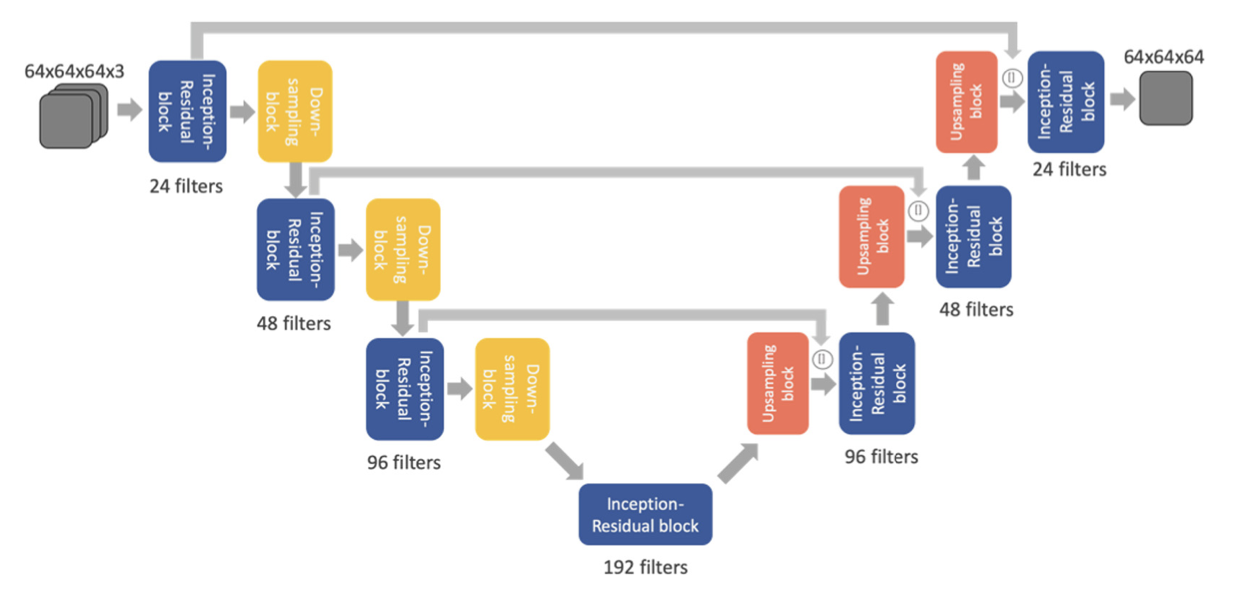

In [13]:
# Nombre de la capa según el nº de filtros empleados
class minet(nn.Module):
    def __init__(self):
        super(minet, self).__init__()
        self.residual_inception_block24_down = residual_inception_block_shortcut(3, 24) # No coincide entrada y salida, residual debe ser modificado
        #self.residual_inception_block24_down = residual_inception_block_shortcut(4, 24) # No coincide entrada y salida, residual debe ser modificado
        self.downsampling_block48 = downsampling_block(24,48)
        self.residual_inception_block48_down = residual_inception_block(48, 48)
        self.downsampling_block96 = downsampling_block(48,96)
        self.residual_inception_block96_down = residual_inception_block(96, 96)
        self.downsampling_block192 = downsampling_block(96,192)
        self.residual_inception_block192 = residual_inception_block(192, 192)
        self.upsampling_block96 = upsampling_block(192,96)
        self.residual_inception_block96_up = residual_inception_block_shortcut(96*2, 96) # se concatena con el residual, la entrada es 2*nºfiltros
        self.upsampling_block48 = upsampling_block(96,48)
        self.residual_inception_block48_up = residual_inception_block_shortcut(48*2, 48) # se concatena con el residual, la entrada es 2*nºfiltros
        self.upsampling_block24 = upsampling_block(48,24)
        self.residual_inception_block24_up = residual_inception_block_shortcut(24*2, 24) # 24 filtros en imagen. se concatena con el residual, la entrada es 2*nºfiltros
        #self.final_block = simple_block(24,3,1) # conv, relu, BN de 1x1x1 para adaptar al nº de canales de la salida
        self.final_block = simple_block(24,4,1) # out_channels = numclasses + 1 (background)
    def forward(self, x):
        residual_inception_block24_down = self.residual_inception_block24_down(x)
        downsampling_block48 = self.downsampling_block48(residual_inception_block24_down)
        residual_inception_block48_down = self.residual_inception_block48_down(downsampling_block48)
        downsampling_block96 = self.downsampling_block96(residual_inception_block48_down)
        residual_inception_block96_down = self.residual_inception_block96_down(downsampling_block96)
        downsampling_block192 = self.downsampling_block192(residual_inception_block96_down)
        residual_inception_block192 = self.residual_inception_block192(downsampling_block192)
        upsampling_block96 = self.upsampling_block96(residual_inception_block192)
        long_skip_connection96 = torch.cat([upsampling_block96, residual_inception_block96_down], 1) # Concatenar salida up96 con resInc96_down (o con entrada?? o sea, down96?)
        residual_inception_block96_up = self.residual_inception_block96_up(long_skip_connection96)
        upsampling_block48 = self.upsampling_block48(residual_inception_block96_up) 
        long_skip_connection48 = torch.cat([upsampling_block48, residual_inception_block48_down], 1) # Concatenar salida up48 con resInc48_down 
        residual_inception_block48_up = self.residual_inception_block48_up(long_skip_connection48) 
        upsampling_block24 = self.upsampling_block24(residual_inception_block48_up) 
        long_skip_connection24 = torch.cat([upsampling_block24, residual_inception_block24_down], 1) # Concatenar salida up24 con resInc24_down 
        residual_inception_block24_up = self.residual_inception_block24_up(long_skip_connection24) 
        finalBlock = self.final_block(residual_inception_block24_up)
        return finalBlock

In [ ]:
net = minet().to(device)
print(net)

## Entrenamiento

In [ ]:
#loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True) # para multilabel
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=True, softmax=True) # para multiclass
#loss_function = DiceCELoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(net.parameters(), 1e-4, weight_decay=1e-5) # elies 1e-3
#optimizer = torch.optim.Adam(net.parameters(), 1e-4)
#optimizer = optim.SGD(net.parameters(), lr=0.1, weight_decay=1e-6)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5) # factor 0.1 de serie. Lo usaremos sobre dice ('accuracy') por lo que maximizaremos
# Learning Rate Annealing (LRA) scheduling
# lr = 0.1     if epoch < 50
# lr = 0.01    if 50 <= epoch < 100
# lr = 0.001   if epoch >= 100
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100], gamma=0.1)

In [37]:
dice_metric = DiceMetric(include_background=True, reduction="mean")
# ???
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")
post_trans = Compose(
    #[EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)] # para multilabel
    [EnsureType(), Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=4)] # numclasses+1, para multiclass
)
# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()

In [ ]:
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True
VAL_AMP = True
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            #roi_size=(240, 240, 160), ## modificar???
            roi_size=(64, 64, 64), # tamaño del patch, ya que si roi > input, hace padding.
            sw_batch_size=1,
            predictor=net,
            overlap=0.2,  ##modificar?? 
        )
    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


In [41]:
def toMultiChannel(data):
  # entra 1 canal, salen 3
  if len(data.shape) == 4:
    data = data[0].type(torch.uint8)
  else:
    data = data.type(torch.uint8)
  zeros = torch.zeros(data.shape, dtype=torch.uint8).to(device)
  unos = torch.ones(data.shape, dtype=torch.uint8).to(device)
  result = []
  # merge label 2 and label 3 to construct TC, 1 y 3(transformado) en 2019
  result.append(torch.where(data==1, unos, zeros))
  # merge labels 1, 2 and 3 to construct WT
  result.append(torch.where(data==2, unos, zeros))
  # label 2 is ET, 3(transformado) en 2019
  result.append(torch.where(data==3, unos, zeros))
  resultado = torch.stack(result, axis=0)
  return resultado

In [ ]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []
print("\n---- Start Training ----")
for epoch in range(epochs):
    net.train()
    epoch_loss = 0
    step = 0
    #for batch_data in train_loader:
    for batch_data in training_loader_patches:
        step += 1
      # num_patches = batch_data["image_patches"].shape[1] # debería ser el mismo que label_patches
      # for patch in range(num_patches):
      #   inputs, labels = (
      #     batch_data["image_patches"][:,patch,:,:].to(device),
      #     batch_data["label_patches"][:,patch,:,:].to(device),
      #   )
        inputs, labels = (
            batch_data["image"][tio.DATA].to(device),
            batch_data["label"][tio.DATA].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = net(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    
    net.eval()
    with torch.no_grad():
        #for val_data in val_loader:
        for val_data in validation_loader_patches:
          # num_patches = val_data["image_patches"].shape[1] # debería ser el mismo que label_patches
          # for patch in range(num_patches):
          #   val_inputs, val_labels = (
          #     val_data["image_patches"][:,patch,:,:].to(device),
          #     val_data["label_patches"][:,patch,:,:].to(device),
          #   )
            val_inputs, val_labels = (
                 val_data["image"][tio.DATA].to(device),
                 val_data["label"][tio.DATA].to(device),
             )
            val_outputs = inference(val_inputs)
            val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
            val_outputs = [toMultiChannel(torch.argmax(i, dim=0)) for i in val_outputs] # Para multiclass, volvemos a convertir en un canal de 4 valores
            val_labels = [i for i in decollate_batch(val_labels)]
            val_labels = [toMultiChannel(i) for i in val_labels]
            dice_metric(y_pred=val_outputs, y=val_labels)
            dice_metric_batch(y_pred=val_outputs, y=val_labels)
        metric = dice_metric.aggregate().item()
        metric_values.append(metric)
        metric_batch = dice_metric_batch.aggregate()
        metric_tc = metric_batch[0].item()
        metric_values_tc.append(metric_tc)
        metric_wt = metric_batch[1].item()
        metric_values_wt.append(metric_wt)
        metric_et = metric_batch[2].item()
        metric_values_et.append(metric_et)
        dice_metric.reset()
        dice_metric_batch.reset()

        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            best_metrics_epochs_and_time[0].append(best_metric)
            best_metrics_epochs_and_time[1].append(best_metric_epoch)
            # torch.save(
            #    net.state_dict(),
            #    os.path.join(root_dir, "best_metric_model.pth"),
            # )
            #print("saved new best metric model")
    for param_group in optimizer.param_groups:
      current_lr = param_group['lr']        
    print(f"[Epoch {epoch + 1}] with LR: {current_lr:.5f} - Average train loss: {epoch_loss:.4f} - Test mean dice: {metric:.2f}%")
    print(f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}")


In [ ]:
torch.save(
  net.state_dict(),
  os.path.join(root_dir, "best_metric_model.pth"),
)

## Inferencia

In [ ]:
# CON datos brats
val_org_transforms = Compose(
    [   LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        EnsureTyped(keys=["image", "label"]),
    ]
)

val_org_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_org_transforms,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=0,
)
val_org_loader = DataLoader(val_org_ds[:1], batch_size=1, shuffle=False, num_workers=1)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=val_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    Activationsd(keys="pred", sigmoid=True),
    AsDiscreted(keys="pred", threshold=0.5),
])

In [ ]:
#device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Cargar modelo
model = minet().to(device)
#model.load_state_dict(torch.load('/content/model_3_channels_label_patches.pth', map_location='cpu'))
model.load_state_dict(torch.load('/content/gdrive/MyDrive/best_metric_model.pth'))
model.eval()

minet(
  (residual_inception_block24_down): residual_inception_block_shortcut(
    (residual): Identity()
    (branch1x1x1): Convolution(
      (conv): Conv3d(3, 24, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      (adn): ADN(
        (A): ReLU()
        (N): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (branch3x3x3): Convolution(
      (conv): Conv3d(3, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (adn): ADN(
        (A): ReLU()
        (N): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (branch3x3x3double_1): Convolution(
      (conv): Conv3d(3, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (adn): ADN(
        (A): ReLU()
        (N): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (branch3x3x3double_2): Convolution(
      (conv): Conv3d(24, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), 

In [ ]:
#x = val_ds[0]['image']
#y = val_ds[0]['label']
#subject = tio.Subject({'image': tio.ScalarImage(tensor=x), 'label': tio.LabelMap(tensor=y)})
subject = training_set[0]
sampler = tio.GridSampler(subject, patch_size=64)
aggregator = tio.data.GridAggregator(sampler, overlap_mode='crop')
aggregator2 = tio.data.GridAggregator(sampler, overlap_mode='crop')
loader = torch.utils.data.DataLoader(sampler, batch_size=1)

In [ ]:
for batch in loader:
  #print(batch['image'][tio.DATA].shape)
  # iterable = zip(batch[tio.LOCATION], batch['image_name'][tio.DATA])
  # for location, data in iterable:
  #   coords_2d = tuple(location[1:3].tolist())
  #   data *= values_dict[coords_2d]
  batch_data = batch['image'][tio.DATA]
  #print(batch_data.shape)
  aggregator.add_batch(batch_data, batch[tio.LOCATION])

In [ ]:
output = aggregator.get_output_tensor()
print(output.shape)
print(x.shape)
print(torch.equal(x, output))

torch.Size([3, 240, 240, 155])
torch.Size([3, 240, 240, 155])
True


In [ ]:
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True
VAL_AMP = True
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(64, 64, 64), ## modificar???
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,  ##modificar?? 
        )
    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)

In [ ]:
for i,subject in enumerate(get_subjects()):
  if i < 1:
    continue
  elif i > 1:
    break
  pred_set = tio.SubjectsDataset(
    [subject], transform=validation_transform)
  sampler = tio.GridSampler(pred_set[0], patch_size=64)
  aggregator = tio.data.GridAggregator(sampler, overlap_mode='crop')
  loader = torch.utils.data.DataLoader(sampler, batch_size=1)
  with torch.no_grad():
      for val_data in loader:
          val_input = val_data["image"][tio.DATA].to(device)
          label = val_data["label"][tio.DATA].to(device)
          val_output = inference(val_input)
          val_output = [torch.argmax(post_trans(i), dim=0, keepdim=True).to(torch.uint8) for i in decollate_batch(val_output)]
          aggregator.add_batch(torch.unsqueeze(val_output[0], dim=0), val_data[tio.LOCATION])
          val_output = [toMultiChannel(i) for i in val_output]
          label = [i for i in decollate_batch(label)]
          label = [toMultiChannel(i) for i in label]
          dice_metric(y_pred=val_output, y=label)
          dice_metric_batch(y_pred=val_output, y=label)

      metric_org = dice_metric.aggregate().item()
      metric_batch_org = dice_metric_batch.aggregate()

      dice_metric.reset()
      dice_metric_batch.reset()

  metric_tc, metric_wt, metric_et = metric_batch_org[0].item(), metric_batch_org[1].item(), metric_batch_org[2].item()

  print("Metric on original image spacing: ", metric_org)
  print(f"metric_tc: {metric_tc:.4f}")
  print(f"metric_wt: {metric_wt:.4f}")
  print(f"metric_et: {metric_et:.4f}")

Metric on original image spacing:  0.6506297588348389
metric_tc: 0.5801
metric_wt: 0.6707
metric_et: 0.6994


In [ ]:
output = aggregator.get_output_tensor()
print(output.shape)
print(torch.unique(output))
print(torch.equal(output.to(torch.uint8), pred_set[0]['label'][tio.DATA]))

torch.Size([1, 240, 240, 155])
tensor([0, 1, 2, 3], dtype=torch.uint8)
False


In [ ]:
output2 = aggregator2.get_output_tensor()
print(output2.shape)
print(torch.equal(output2, val_ds[0]['label']))

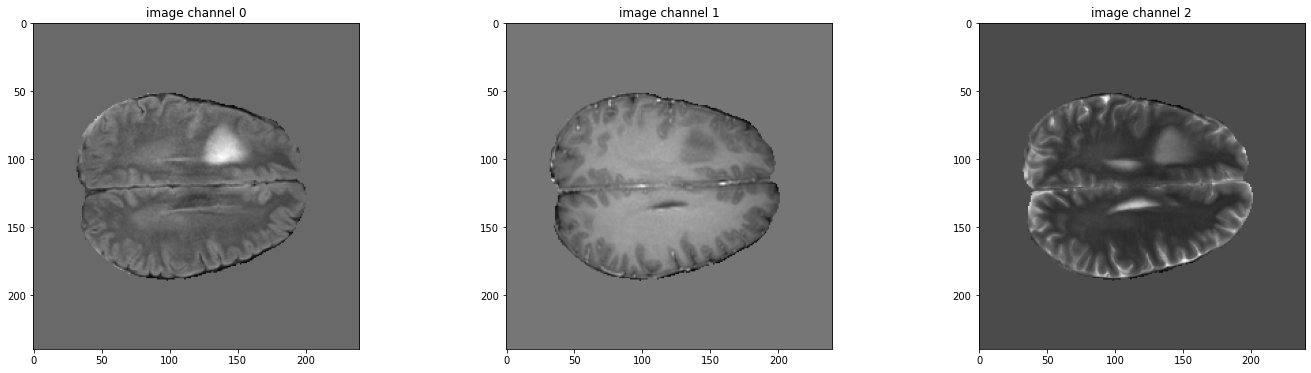

pred shape: torch.Size([1, 240, 240, 155])


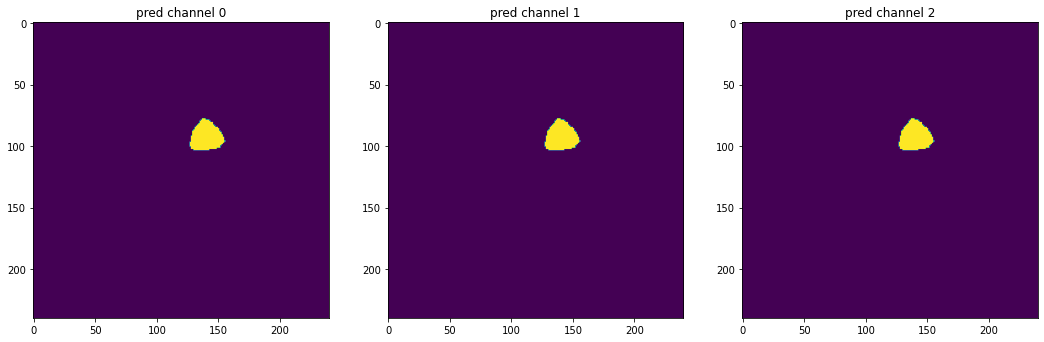

pred shape: torch.Size([1, 240, 240, 155])


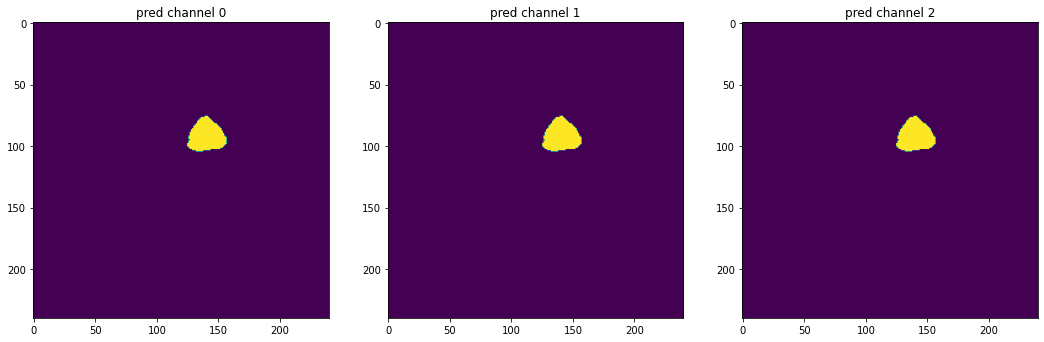

In [ ]:
plt.figure("image", (24, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(pred_set[0]["image"][tio.DATA][i, :, :, 90].detach().cpu(), cmap="gray")
plt.show()
y = pred_set[0]['label'][tio.DATA]
print(f"pred shape: {y.shape}")
plt.figure("pred", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"pred channel {i}")
    plt.imshow(y[0, :, :, 90].detach().cpu())
plt.show()
print(f"pred shape: {output.shape}")
plt.figure("pred", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"pred channel {i}")
    plt.imshow(output[0, :, :, 90].detach().cpu())
plt.show()

In [ ]:
# Guardar la máscara como NifTi
import nibabel as nb

ni_img = nb.Nifti1Image(np.array(output[0]), affine=np.eye(4))
nb.save(ni_img, "dicom_volume_image.nii.gz")

## Patches

In [ ]:
import numpy as np

def standarim(image):
    image = (image - np.mean(image[image > 0]))/np.std(image[image > 0] - np.mean(image[image > 0]))
    return image


def patch_extractor(volume, patch_shape, c_dist):
    """
                Return all patches generated from the volume
                Parameters
                ----------
                    volume : initial volume to extract the patches
                    patch_shape : shape of the output patches
                    c_dist: distance between patches centres
                Returns
                -------
                    Numpy arrays containing [n-patches x n-rows x n-columns x n-depth].
        """
    # define the number of patches
    n_patchesx = int(np.ceil(volume.shape[0] / c_dist[0])) + 1
    n_patchesy = int(np.ceil(volume.shape[1] / c_dist[1])) + 1
    n_patchesz = int(np.ceil(volume.shape[2] / c_dist[2])) + 1

    # generate a zeropadded version of the input volume
    volume_zeropadded = np.zeros([volume.shape[0] + 3 * patch_shape[0], volume.shape[1] + 3 * patch_shape[1], volume.shape[2] + 3 * patch_shape[2]])
    x_emb0 = int(np.ceil(patch_shape[0]/2))
    x_embend = volume.shape[0] + int(np.ceil(patch_shape[0] / 2))
    y_emb0 = int(np.ceil(patch_shape[1] / 2))
    y_embend = volume.shape[1] + int(np.ceil(patch_shape[1] / 2))
    z_emb0 = int(np.ceil(patch_shape[2] / 2))
    z_embend = volume.shape[2] + int(np.ceil(patch_shape[2] / 2))
    volume_zeropadded[x_emb0:x_embend, y_emb0:y_embend, z_emb0:z_embend] = volume

    # create and fill the array containing the patches
    patches = np.zeros([n_patchesx * n_patchesy * n_patchesz, patch_shape[0], patch_shape[1], patch_shape[2] ])
    count = 0
    for t1 in range(0, n_patchesx):
        for t2 in range(0, n_patchesy):
            for t3 in range(0, n_patchesz):
                x0 = x_emb0 + int(t1*c_dist[0]-np.ceil(patch_shape[0]/2))
                xend= x_emb0 + int(t1*c_dist[0]+np.floor(patch_shape[0]/2))
                y0 = y_emb0 + int(t2 * c_dist[1] - np.ceil(patch_shape[1] / 2))
                yend = y_emb0 + int(t2 * c_dist[1] + np.floor(patch_shape[1] / 2))
                z0 = z_emb0 + int(t3 * c_dist[2] - np.ceil(patch_shape[2] / 2))
                zend = z_emb0 + int(t3 * c_dist[2] + np.floor(patch_shape[2] / 2))

                patches[count, :, :, :] = volume_zeropadded[x0: xend, y0: yend, z0: zend]
                count = count+1

    return patches



def patch_composer(patches, patch_shape, c_dist, volumeshape):
    """
            Return the original volume from all patches.
            Parameters
            ----------
                patches : numpy array created with patch_extractor_mask
                patch_shape : shape of the output patches
                c_dist: distance between patches centres
                volumeshape : shape of the initial volume to extract the patches
            Returns
            -------
                Numpy arrays containing the original volume
    """

    # define the number of patches
    n_patchesx = int(np.ceil(volumeshape[0] / c_dist[0])) + 1
    n_patchesy = int(np.ceil(volumeshape[1] / c_dist[1])) + 1
    n_patchesz = int(np.ceil(volumeshape[2] / c_dist[2])) + 1

    # generate a zeropadded version of the volume
    volume_zeropadded = np.zeros([volumeshape[0] + 3 * patch_shape[0], volumeshape[1] + 3 * patch_shape[1], volumeshape[2] + 3 * patch_shape[2]])
    x_emb0 = int(np.ceil(patch_shape[0]/2))
    x_embend = volumeshape[0] + int(np.ceil(patch_shape[0] / 2))
    y_emb0 = int(np.ceil(patch_shape[1] / 2))
    y_embend = volumeshape[1] + int(np.ceil(patch_shape[1] / 2))
    z_emb0 = int(np.ceil(patch_shape[2] / 2))
    z_embend = volumeshape[2] + int(np.ceil(patch_shape[2] / 2))

    # compose the zeroppaded version of the volume with the patches
    count = 0
    for t1 in range(0, n_patchesx):
        for t2 in range(0, n_patchesy):
            for t3 in range(0, n_patchesz):
                x0 = x_emb0 + int(t1 * c_dist[0] - np.ceil(patch_shape[0] / 2))
                xend = x_emb0 + int(t1 * c_dist[0] + np.floor(patch_shape[0] / 2))
                y0 = y_emb0 + int(t2 * c_dist[1] - np.ceil(patch_shape[1] / 2))
                yend = y_emb0 + int(t2 * c_dist[1] + np.floor(patch_shape[1] / 2))
                z0 = z_emb0 + int(t3 * c_dist[2] - np.ceil(patch_shape[2] / 2))
                zend = z_emb0 + int(t3 * c_dist[2] + np.floor(patch_shape[2] / 2))

                volume_zeropadded[x0: xend, y0: yend, z0: zend] = patches[count, :, :, :]
                count = count+1

    # recompose the zeroppaded version of the volume with the patches using a different order and averaging intensities. This ensures the averaging of the overlaped regions
    count = count-1
    for t1 in range(n_patchesx-1, -1, -1):
        for t2 in range(n_patchesy-1, -1, -1):
            for t3 in range(n_patchesz-1, -1, -1):
                x0 = x_emb0 + int(t1 * c_dist[0] - np.ceil(patch_shape[0] / 2))
                xend = x_emb0 + int(t1 * c_dist[0] + np.floor(patch_shape[0] / 2))
                y0 = y_emb0 + int(t2 * c_dist[1] - np.ceil(patch_shape[1] / 2))
                yend = y_emb0 + int(t2 * c_dist[1] + np.floor(patch_shape[1] / 2))
                z0 = z_emb0 + int(t3 * c_dist[2] - np.ceil(patch_shape[2] / 2))
                zend = z_emb0 + int(t3 * c_dist[2] + np.floor(patch_shape[2] / 2))

                volume_zeropadded[x0: xend, y0: yend, z0: zend] = (patches[count, :, :, :] + volume_zeropadded[x0: xend, y0: yend, z0: zend])/2
                count = count-1


    # delete the zeroppaded region from the volume
    volume = volume_zeropadded[x_emb0:x_embend, y_emb0:y_embend, z_emb0:z_embend]

    return volume

In [ ]:
# patches de tamaño 64x64x64 con espacio 64 entre sus centros. Da 100 patches como resultado.
class Patched(MapTransform):
# Obtenemos por separado los canales que sean, y los juntamos para formar una imagen de n canales
    def __call__(self, data):
        d = dict(data)
        # recorremos los canales, hacemos patches de cada uno, y stackeamos
        for key in self.keys:
          result = []
          for canal in range(d[key].shape[0]):
              patches = patch_extractor(d[key][canal], [64,64,64], [64,64,64]) # Canal i
              result.append(patches)
          d[key + '_patches'] = np.stack(result, axis=1).astype(np.float32)
        return d

Sin aplicar patches torch.Size([4, 224, 224, 144])


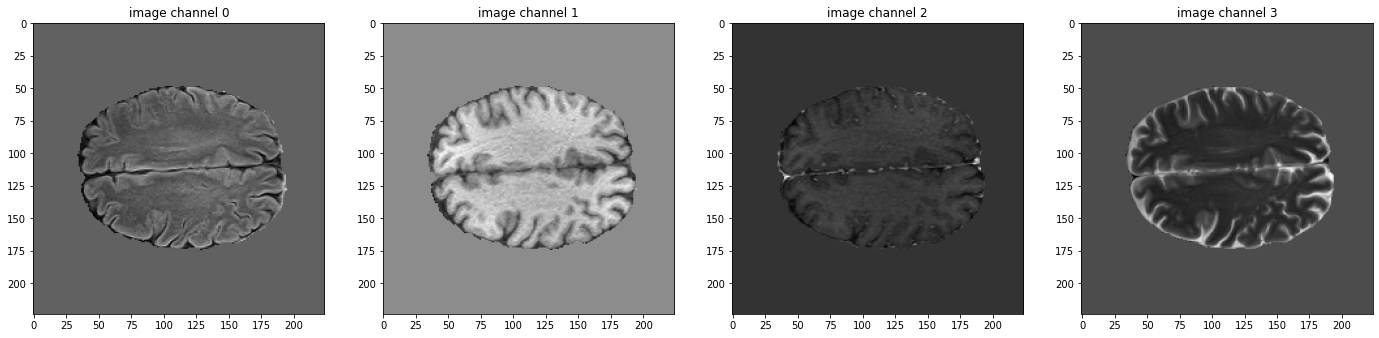

In [ ]:
#val_data_example = val_org_ds[2]
val_data_example = train_ds[2]
prueva = Patched(keys="image")
dato = val_data_example
print('Sin aplicar patches', dato['image'].shape)
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(dato["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()
# dato2 = prueva(dato) 
# print('Aplicamos ConvertToMultiChannelBasedOnBratsClassesd ahora')
# print(f"label shape: {dato2['label'].shape}")
# for i in range(3):
#     plt.subplot(1, 3, i + 1)
#     plt.title(f"label channel {i}")
#     plt.imshow(torch.tensor(dato2["label"])[i, :, :, 60].detach().cpu())
# plt.show()

In [ ]:
dato['image'][0].shape

torch.Size([224, 224, 144])

In [ ]:
patches = patch_extractor(dato['label'][2], [64,64,64], [64,64,64])
patches.shape

(100, 64, 64, 64)

In [ ]:
repatched = patch_composer(patches, [64,64,64], [64,64,64], dato['label'][2].shape)
print(repatched.shape)
repatched_tensor = torch.tensor(repatched, dtype=torch.float)
print(repatched_tensor.shape)

(224, 224, 144)
torch.Size([224, 224, 144])


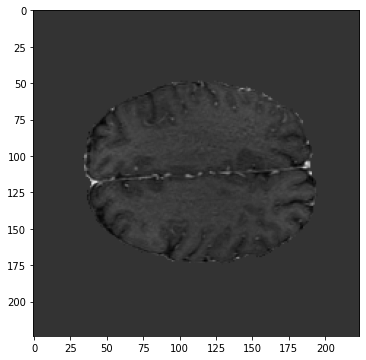

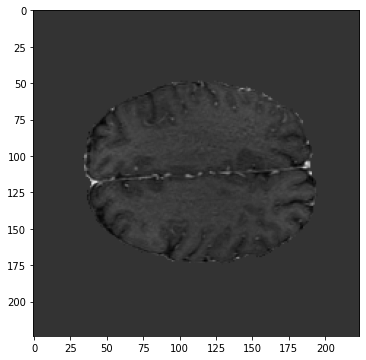

In [ ]:
plt.figure("image", (18, 6))
plt.imshow(dato["image"][2][:, :, 60].detach().cpu(), cmap="gray")
plt.show()
plt.figure("image", (18, 6))
plt.imshow(repatched[:, :, 60], cmap="gray")
plt.show()

In [ ]:
torch.equal(repatched_tensor, dato["label"][2])

True

In [ ]:
print(dato['image'].shape)
patches_0 = patch_extractor(dato['image'][0], [64,64,64], [64,64,64]) # Canal 0
patches_1 = patch_extractor(dato['image'][1], [64,64,64], [64,64,64]) # Canal 1
patches_2 = patch_extractor(dato['image'][2], [64,64,64], [64,64,64]) # Canal 2
patches_3 = patch_extractor(dato['image'][3], [64,64,64], [64,64,64]) # Canal 3
print(patches_0.shape)
patches_complete = np.stack([patches_0, patches_1, patches_2, patches_3], axis=1).astype(np.float32)
print(patches_complete.shape)
patches_list = [patch for patch in patches_complete]
patches_list[0].shape

torch.Size([4, 240, 240, 155])
(100, 64, 64, 64)
(100, 4, 64, 64, 64)


(4, 64, 64, 64)

In [ ]:
# val_org_transforms = Compose(
#     [   LoadImaged(keys=["image", "label"]),
#         EnsureChannelFirstd(keys=["image"]),
#         ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
#         Orientationd(keys=["image"], axcodes="RAS"),
#         Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
#         NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
#         EnsureTyped(keys=["image", "label"]),
#     ]
# )

# val_org_ds = DecathlonDataset(
#     root_dir='/tmp/tmpid7khdef',
#     task="Task01_BrainTumour",
#     transform=val_org_transforms,
#     section="validation",
#     download=False,
#     num_workers=4,
#     cache_num=0,
# )
patches_dataset = CacheDataset(data=patches_list[:1], transform=None, cache_rate=1.0, num_workers=2)
patches_loader = DataLoader(patches_dataset, batch_size=1, shuffle=False, num_workers=1)

Loading dataset: 100%|██████████| 2/2 [00:00<00:00, 11244.78it/s]


In [ ]:
salidas = []
with torch.no_grad():
    for val_data in patches_loader:
        val_inputs = val_data.to(device)
        #val_data["pred"] = inference(val_inputs)
        aux = inference(val_inputs)
        #salidas.append(aux)
#         val_data = [post_transforms(i) for i in decollate_batch(val_data)]
#         val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
#         dice_metric(y_pred=val_outputs, y=val_labels)
#         dice_metric_batch(y_pred=val_outputs, y=val_labels)

#     metric_org = dice_metric.aggregate().item()
#     metric_batch_org = dice_metric_batch.aggregate()

#     dice_metric.reset()
#     dice_metric_batch.reset()

# metric_tc, metric_wt, metric_et = metric_batch[0].item(), metric_batch[1].item(), metric_batch[2].item()

# print("Metric on original image spacing: ", metric)
# print(f"metric_tc: {metric_tc:.4f}")
# print(f"metric_wt: {metric_wt:.4f}")
# print(f"metric_et: {metric_et:.4f}")

In [ ]:
print(train_ds[2]['image'].shape)
print(train_ds[2]['image_patches'].shape)
print(train_ds[2]['label'].shape)
print(train_ds[2]['label_patches'].shape)

torch.Size([4, 224, 224, 144])
(100, 4, 64, 64, 64)
torch.Size([3, 224, 224, 144])
(100, 3, 64, 64, 64)


In [ ]:
val_ds[2]['image_patches'][:,0,:,:].shape

(100, 64, 64, 64)

In [ ]:
# Comprobar que los patches repatcheados son equivalentes al original
repatched = patch_composer(val_ds[2]['image_patches'][:,2,:,:], [64,64,64], [64,64,64], val_ds[2]['image'][2].shape)
print(repatched.shape)
repatched_tensor = torch.tensor(repatched, dtype=torch.float)
print(repatched_tensor.shape)
print(torch.equal(repatched_tensor, val_ds[2]["image"][2]))

(240, 240, 155)
torch.Size([240, 240, 155])
True


In [ ]:
prueba = np.array([data['label'] for data in patches_val_ds[100:200]])
print(prueba.shape)

(100, 3, 64, 64, 64)


In [ ]:
torch.equal(torch.tensor(prueba, dtype=torch.float), torch.tensor(val_ds[1]['label_patches'], dtype=torch.float))

True

In [ ]:
print(val_ds[0]['image'].shape)
print(val_ds[0]['image_patches'].shape)
print(torch.tensor(patches_val_ds, dtype=torch.float).shape)

torch.Size([4, 240, 240, 155])
(100, 4, 64, 64, 64)
torch.Size([200, 4, 64, 64, 64])


In [ ]:
# Comprobar que los patches repatcheados son equivalentes al original
repatched = patch_composer(prueba[:,0,:,:,:], [64,64,64], [64,64,64], val_ds[0]['image'][0].shape)
print(repatched.shape)
repatched_tensor = torch.tensor(repatched, dtype=torch.float)
print(repatched_tensor.shape)
print(torch.equal(repatched_tensor, val_ds[0]["image"][0]))

(240, 240, 155)
torch.Size([240, 240, 155])
True


## Patches PyTorch

In [ ]:
# patches de tamaño 64x64x64 con espacio 64 entre sus centros. Da 18 patches como resultado.
class Patched(MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
          patches = d[key].unfold(1, 64, 64).unfold(2, 64, 64).unfold(3, 64, 64)
          patches = patches.contiguous().view(-1, patches.size(0), 64, 64, 64)
          d[key + '_patches'] = patches
        return d

In [ ]:
x = val_ds[2]['image'] # uno de los canales, cojemos también el canal 1 como si fuera batch_size
y = val_ds[2]['label']
print(x.shape)

torch.Size([4, 240, 240, 155])


In [ ]:
# RECORTAR antes el borde, background, a ras y hacer padding desde ahí
# Añadir padding para que la imagen sea múltiplo de 64 al dividir en patches
import torch.nn.functional as F
PaddedMR = F.pad(x, (2, 3, 9, 10, 2, 3), 'constant') 
PaddedMR.shape

In [ ]:
val_ds[2]['image_patches'].shape

torch.Size([18, 4, 64, 64, 64])

In [ ]:
# tamaño patch ((c + 2*padding - dilation * (kernel_size - 1) - 1) / stride + 1)
# resumido (input  - (kernel_size - 1) - 1) /stride + 1
# t = (input - kernel)/s + 1
kc, kh, kw = 64, 64, 64  # kernel size
dc, dh, dw = 58, 58, 31  # stride
# overlap ki-di en la dimensión i
patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
unfold_shape = patches.size()
patches = patches.contiguous().view(-1, patches.size(0), kc, kh, kw)
print(patches.shape)
print(unfold_shape)

torch.Size([48, 4, 64, 64, 64])
torch.Size([4, 4, 4, 3, 64, 64, 64])


In [ ]:
lel = patches.view(-1,4,4,3,64,64,64)
lel.shape

torch.Size([4, 4, 4, 3, 64, 64, 64])

In [ ]:
patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
torch.equal(lel, patches)

True

In [ ]:
assadssa = [1,2,3,4,5]
print(assadssa[-2:])

[4, 5]


In [ ]:
viewed = patches.view(-1,4,4,3,64,64,64)
print(x.shape)
print(viewed.shape)
# inicializamos con los primeros -(ki-di) (zona sin overlap) del primer patch
prueba = viewed[:, 0, 0, 0, :-(kc-dc), :-(kh-dh), :-(kw-dw)] # no overlap primer patch
prueba2 = viewed[:, 0, 0, 0, -(kc-dc):, -(kh-dh):, -(kw-dw):] # overlap primer patch (este sólo tiene por la derecha)
print(prueba.shape)
print(prueba2.shape)
for i in range(viewed.shape[1]): # primera dimensión de la imagen 3D
  overlap_1 = viewed[:, 0, 0, 0, -(kc-dc):, -(kh-dh):, -(kw-dw):]
  prueba = torch.cat((prueba, patches[1]), axis=1)
print(prueba.shape)

In [ ]:
patches[0].shape

torch.Size([4, 64, 64, 64])

In [ ]:
patches[1][:, kc-dc:,kh-dh:, kw-dw:].shape

torch.Size([4, 58, 58, 31])

In [ ]:
kc, kh, kw = 64, 64, 64  # kernel size
dc, dh, dw = 64, 64, 64  # stride
y_patches = y.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
y_unfold_shape = y_patches.size()
y_patches = y_patches.contiguous().view(-1, y_patches.size(0), kc, kh, kw)
print(y_patches.shape)

torch.Size([18, 3, 64, 64, 64])


In [ ]:
# Reshape back
patches_orig = patches.view(unfold_shape)
output_c = unfold_shape[1] * unfold_shape[4]
output_h = unfold_shape[2] * unfold_shape[5]
output_w = unfold_shape[3] * unfold_shape[6]
patches_orig = patches_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
patches_orig = patches_orig.view(4, output_c, output_h, output_w)

In [ ]:
# Check for equality
print((patches_orig == x[:, :output_c, :output_h, :output_w]).all())

RuntimeError: ignored

In [ ]:
# Reshape back
y_patches_orig = y_patches.view(y_unfold_shape)
output_c = y_unfold_shape[1] * y_unfold_shape[4]
output_h = y_unfold_shape[2] * y_unfold_shape[5]
output_w = y_unfold_shape[3] * y_unfold_shape[6]
y_patches_orig = y_patches_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
y_patches_orig = y_patches_orig.view(3, output_c, output_h, output_w)

In [ ]:
# Check for equality
print((y_patches_orig == y[:, :output_c, :output_h, :output_w]).all())

tensor(True)


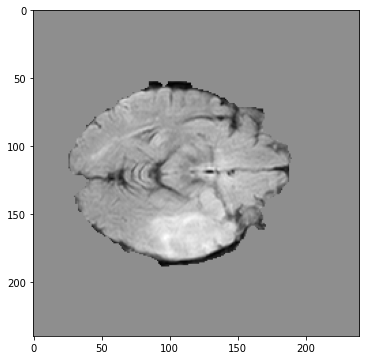

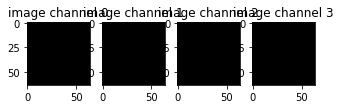

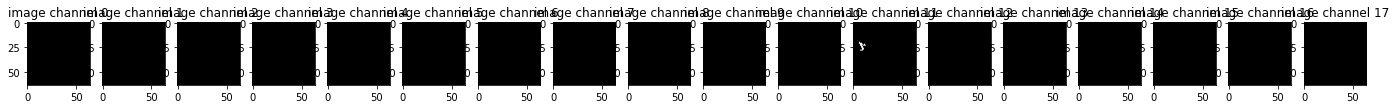

In [ ]:
plt.figure("image", (18, 6))
plt.imshow(x[0, :, :, 60].detach().cpu(), cmap="gray")
plt.show()
plt.figure("image", (24, 6))
for i in range(patches.shape[0]):
    plt.subplot(1, 18, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(patches[i, 0, :, :, 32].detach().cpu(), cmap="gray")
plt.show()
plt.figure("image", (24, 6))
for i in range(y_patches.shape[0]):
    plt.subplot(1, 18, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(y_patches[i, 1, :, :, 32].detach().cpu(), cmap="gray")
plt.show()

In [ ]:
x.shape

torch.Size([4, 240, 240, 155])

In [ ]:
patches_orig.shape

torch.Size([4, 256, 192, 256])

In [ ]:
y.shape

torch.Size([3, 240, 240, 155])

In [ ]:
y_patches_orig.shape

torch.Size([3, 192, 192, 128])

## Patches TorchIO

In [14]:
%pip install torchio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 166 kB 34.4 MB/s 
     |████████████████████████████████| 48.4 MB 1.2 MB/s 


In [15]:
import torchio as tio

In [ ]:
# patches de tamaño 64x64x64 con espacio 64 entre sus centros. Da 18 patches como resultado.
class Patched(MapTransform):
    def __call__(self, data):
        d = dict(data)
        x = d['image']
        y = d['label']
        subject = tio.Subject({'image': tio.ScalarImage(tensor=x), 'label': tio.LabelMap(tensor=y)})
        d['patches'] = subject
        return d

In [ ]:
x = val_ds[2]['image']
y = val_ds[2]['label']
# Dividir en patches
#sampler = tio.GridSampler(patch_size=(a,b,c), patch_overlap = (x,y,z))
subject = tio.Subject({'image': tio.ScalarImage(tensor=x), 'label': tio.LabelMap(tensor=y)})
sampler = tio.GridSampler(subject, patch_size=64)
aggregator = tio.data.GridAggregator(sampler, overlap_mode='average')

In [ ]:
print(len(sampler)) # nº batches

48


In [ ]:
for i, patch in enumerate(sampler(subject)):
    #patch.t1.save(f'patch_{i}.nii.gz')
    print(i)
    #print(patch.shape)

In [ ]:
loader = torch.utils.data.DataLoader(sampler, batch_size=3)
for batch in loader:
  print(batch['image'][tio.DATA].shape)
  # iterable = zip(batch[tio.LOCATION], batch['image_name'][tio.DATA])
  # for location, data in iterable:
  #   coords_2d = tuple(location[1:3].tolist())
  #   data *= values_dict[coords_2d]
  batch_data = batch['label'][tio.DATA]
  aggregator.add_batch(batch_data, batch[tio.LOCATION])

torch.Size([3, 4, 64, 64, 64])
torch.Size([3, 4, 64, 64, 64])
torch.Size([3, 4, 64, 64, 64])
torch.Size([3, 4, 64, 64, 64])
torch.Size([3, 4, 64, 64, 64])
torch.Size([3, 4, 64, 64, 64])
torch.Size([3, 4, 64, 64, 64])
torch.Size([3, 4, 64, 64, 64])
torch.Size([3, 4, 64, 64, 64])
torch.Size([3, 4, 64, 64, 64])
torch.Size([3, 4, 64, 64, 64])
torch.Size([3, 4, 64, 64, 64])
torch.Size([3, 4, 64, 64, 64])
torch.Size([3, 4, 64, 64, 64])
torch.Size([3, 4, 64, 64, 64])
torch.Size([3, 4, 64, 64, 64])


In [ ]:
# Recontruir la imagen a partir de los patches
output = aggregator.get_output_tensor()
print(output.shape)
print(x.shape)
print(torch.equal(y, output))

torch.Size([3, 240, 240, 155])
torch.Size([4, 240, 240, 155])
True


In [ ]:
train_subjects = [data['patches'] for data in train_ds[:1]]
val_subjects = [data['patches'] for data in val_ds[:1]]

In [ ]:
# Transforms ya aplicadas en subjects, ya que los obtenemos del train y val dataset
training_set = tio.SubjectsDataset(
    train_subjects, transform=None)

validation_set = tio.SubjectsDataset(
    val_subjects, transform=None)

In [ ]:
training_set[0]['sampling_map'][tio.DATA].shape

torch.Size([3, 224, 224, 144])

In [ ]:
samplig_map = torch.load('map.pt')
samplig_map.shape

torch.Size([3, 240, 240, 155])

In [ ]:
x = torch.ones(240,240,155)
samplig_map2 = samplig_map[:,8:232, 8:232, 5:149]
samplig_map2.shape

torch.Size([3, 224, 224, 144])

In [ ]:
training_batch_size = 1 #len(tio.GridSampler(train_subjects[0], patch_size=64))
validation_batch_size = 1 #2 * len(tio.GridSampler(val_subjects[0], patch_size=64))

x = val_ds[2]['image']
y = val_ds[2]['label']
# Dividir en patches
#sampler = tio.GridSampler(patch_size=(a,b,c), patch_overlap = (x,y,z))
subject = tio.Subject({'image': tio.ScalarImage(tensor=x), 'label': tio.LabelMap(tensor=y)})

#sampler = tio.GridSampler(subject, patch_size=64)
train_samples_per_volume = len(tio.GridSampler(subject, patch_size=64))
val_samples_per_volume = len(tio.GridSampler(subject, patch_size=64))
max_queue_length = len(tio.GridSampler(subject, patch_size=64))
sampler = tio.data.UniformSampler(patch_size=64) # Patches aleatorios del volumen
#sampler = tio.data.GridSampler(patch_size=64) # Divide el volumen entero en patches
#sampler = tio.data.WeightedSampler(64, 'sampling_map')
# Pondremos que haya 50% sin label y 50% con label (de cualquiera de las 3 clases, equiprobable)
#probabilities = {0:3, 1:1, 2:1 ,3:1} # Probabilidades de que cada patch tengo por centro 0 (no label), 1 (clase 1)...
#sampler = tio.data.LabelSampler(patch_size=64, label_name='label', label_probabilities=probabilities)

patches_training_set = tio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=train_samples_per_volume,
    sampler=sampler,
    num_workers=1,
    shuffle_subjects=True,
    shuffle_patches=True,
)

patches_validation_set = tio.Queue(
    subjects_dataset=validation_set,
    max_length=max_queue_length,
    samples_per_volume=val_samples_per_volume,
    sampler=sampler,
    num_workers=1,
    shuffle_subjects=False,
    shuffle_patches=False,
)

training_loader_patches = torch.utils.data.DataLoader(
    patches_training_set, batch_size=training_batch_size)

validation_loader_patches = torch.utils.data.DataLoader(
    patches_validation_set, batch_size=validation_batch_size)

In [ ]:
train_samplers = [tio.data.GridSampler(subject, patch_size=64) for subject in train_subjects]
train_loader = torch.utils.data.DataLoader(train_samplers, batch_size=3)
val_samplers = [tio.data.GridSampler(subject, patch_size=64) for subject in val_subjects]
val_loader = torch.utils.data.DataLoader(val_samplers, batch_size=3)

In [ ]:
one_batch = next(iter(training_loader_patches))

In [ ]:
print(len(training_loader_patches))

48


In [ ]:
print(val_ds[0]['patches']['sampling_map'])

Image(shape: (3, 240, 240, 155); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 102.2 MiB)


In [ ]:
for lal in training_loader_patches:
  print(lal)
  break

{'image': {'data': tensor([[[[[-0.0945, -0.0945, -0.0945,  ..., -0.0945, -0.0945, -0.0945],
           [-0.0945, -0.0945, -0.0945,  ..., -0.0945, -0.0945, -0.0945],
           [-0.0945, -0.0945, -0.0945,  ..., -0.0945, -0.0945, -0.0945],
           ...,
           [-0.0945, -0.0945, -0.0945,  ..., -0.0945, -0.0945, -0.0945],
           [-0.0945, -0.0945, -0.0945,  ..., -0.0945, -0.0945, -0.0945],
           [-0.0945, -0.0945, -0.0945,  ..., -0.0945, -0.0945, -0.0945]],

          [[-0.0945, -0.0945, -0.0945,  ..., -0.0945, -0.0945, -0.0945],
           [-0.0945, -0.0945, -0.0945,  ..., -0.0945, -0.0945, -0.0945],
           [-0.0945, -0.0945, -0.0945,  ..., -0.0945, -0.0945, -0.0945],
           ...,
           [-0.0945, -0.0945, -0.0945,  ..., -0.0945, -0.0945, -0.0945],
           [-0.0945, -0.0945, -0.0945,  ..., -0.0945, -0.0945, -0.0945],
           [-0.0945, -0.0945, -0.0945,  ..., -0.0945, -0.0945, -0.0945]],

          [[-0.0945, -0.0945, -0.0945,  ..., -0.0945, -0.0945, -0.094

In [ ]:
sampler2 = tio.GridSampler(val_ds[0]['patches'], patch_size=64)
aggregator = tio.data.GridAggregator(sampler2, overlap_mode='average')
aggregator2 = tio.data.GridAggregator(sampler2, overlap_mode='average')
for batch_data in training_loader_patches:
  label = batch_data['label'][tio.DATA]
  image = batch_data['image'][tio.DATA]
  aggregator.add_batch(label, batch_data[tio.LOCATION])
  aggregator2.add_batch(image, batch_data[tio.LOCATION])

RuntimeError: ignored

In [ ]:
output = aggregator.get_output_tensor()
print(output.shape)
output2 = aggregator2.get_output_tensor()
print(torch.equal(val_ds[0]['image'], output2))

torch.Size([3, 240, 240, 155])
True


In [ ]:
torch.equal(val_ds[2]['label'], validation_set[2]['label'][tio.DATA])

True

## Dataset 2021 (directamente con TIO)

In [16]:
from pathlib import Path

In [17]:
data_path = Path(root_dir + '/BraTS2021_Training_Data')

In [18]:
image_names = ['flair', 't1c', 't2', 'seg'] # Añadir 't1.' si se quieren usar los 4 canales. seg es el label

In [19]:
def get_subjects():
  # for folder in data_path.iterdir():
  #   if folder.is_dir():
  #     if folder.name == 'HGG':
  #       is_HGG = True
  #     elif folder.name == 'LGG':
  #       is_HGG = False
  #     for sample in folder.iterdir():
     for sample in data_path.iterdir():
        if (not sample.is_dir()) or (sample.name.startswith('.')):
          continue
        dict_paths = {}
        # if sample.name != 'BraTS19_TCIA13_653_1':
        #   continue
        #print(sample.name)
        for image in sample.iterdir():
          for name in image_names:
            if name in image.name:
              dict_paths[name] = str(image)
              break  
        subject = tio.Subject(
            flair = tio.ScalarImage(dict_paths['flair']),
            # t1 = tio.ScalarImage(dict_paths['t1.']), # Si queremos usar los 4 canales
            t1c = tio.ScalarImage(dict_paths['t1c']),
            t2 = tio.ScalarImage(dict_paths['t2']),
            label=tio.LabelMap(dict_paths['seg']),
            #HGG = is_HGG
        )
        # print(dict_paths['flair'])
        # print(dict_paths['t1c'])
        # print(dict_paths['seg'])
        
        yield subject

In [20]:
from torchio.transforms import Transform
from torchio.data.subject import Subject
from torchio.typing import Sequence, Optional
from torchio.typing import TypeCallable

class StackChannels(Transform):
  def apply_transform(self, subject: Subject) -> Subject:
      channels = [subject[channel][tio.DATA][0] for channel in image_names[:-1]] # Stackeamos todos los canales excepto el último, que es el label
      stacked = torch.stack(channels, axis=0)
      subject['image'] = tio.ScalarImage(tensor = stacked)
      for channel in image_names:
        if channel == 'seg':
          aux = subject['label'][tio.DATA]
          subject['label'] = tio.LabelMap(tensor = aux)
        else:
          aux = subject[channel][tio.DATA]
          subject[channel] = tio.ScalarImage(tensor = aux)
      return subject

In [21]:
# De serie las labels son 0,1,2 y 4. No se puede saltar un número. Convertiremos el 4 en 3.
class ChangeLabels(Transform):
  def apply_transform(self, subject: Subject) -> Subject:
      subject['label'][tio.DATA][subject['label'][tio.DATA]==4] = 3
      return subject

In [22]:
from torchio.transforms import ZNormalization

class ZNormalizationNoZeros(ZNormalization):
    @staticmethod
    def znorm(tensor: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        tensor = tensor.clone().float()
        values = tensor.masked_select(mask)
        non_zero_index = torch.nonzero(values, as_tuple=True) # índices con los elementos no 0
        values = values[non_zero_index]# quitamos los 0s, es decir, el background
        mean, std = values.mean(), values.std()
        if std == 0:
            return None
        tensor = (tensor>0)*-mean + tensor # Restamos la media a los elementos que no son background
        tensor /= std # no hace falta cambiarlo ya que 0/x es 0
        return tensor

In [23]:
training_transform = tio.Compose([
    tio.ToCanonical(),
    ChangeLabels(),
    ZNormalizationNoZeros(exclude='label'), # normalizar los canales antes de stackear
    StackChannels(),
    #ZNormalizationNoZeros(include='image'), # o normalizarlos stackeados despues
    # ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
    # deleteT1(keys = 'image'),
    # tio.Resample(4),
    # tio.CropOrPad((48, 60, 48)),
    # tio.RandomMotion(p=0.2),
    # tio.HistogramStandardization({'mri': landmarks}),
    # tio.RandomBiasField(p=0.3),
    # tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    # tio.RandomNoise(p=0.5),
    # tio.RandomFlip(),
    # tio.OneOf({
    #     tio.RandomAffine(): 0.8,
    #     tio.RandomElasticDeformation(): 0.2,
    # }),
    # tio.OneHot(),
])

validation_transform = tio.Compose([
    tio.ToCanonical(),
    ChangeLabels(),
    ZNormalizationNoZeros(exclude='label'), # normalizar los canales antes de stackear
    StackChannels(),
    #ZNormalizationNoZeros(include='image'), # o normalizarlos stackeados despues
    #ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
    #deleteT1(keys = 'image'),
    #NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    #tio.ZNormalization(masking_method=lambda x: x > x.mean()),
    #tio.RescaleIntensity((-1, 1))
    # tio.Resample(4),
    # tio.CropOrPad((48, 60, 48)),
    # tio.HistogramStandardization({'mri': landmarks}),
    #tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    # tio.OneHot(),
])

In [ ]:
subjects = [x for x in get_subjects()][120:122]

BraTS19_TCIA13_653_1


In [ ]:
training_subjects = subjects[:1]
validation_subjects = subjects[1:]

In [ ]:
training_split_ratio = 0.8  # use 80% of samples for training, 10% for testing

num_subjects = len(subjects)
num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects

num_split_subjects = num_training_subjects, num_validation_subjects
training_subjects, validation_subjects = torch.utils.data.random_split(subjects, num_split_subjects)

In [ ]:
training_set = tio.SubjectsDataset(
    training_subjects, transform=training_transform)

validation_set = tio.SubjectsDataset(
    validation_subjects, transform=validation_transform)

NameError: ignored

In [39]:
def toMultiChannel(data):
  # entra 1 canal, salen 3
  if len(data.shape) == 4:
    data = data[0].type(torch.uint8)
  else:
    data = data.type(torch.uint8)
  zeros = torch.zeros(data.shape, dtype=torch.uint8)
  unos = torch.ones(data.shape, dtype=torch.uint8)
  result = []
  # merge label 2 and label 3 to construct TC, 1 y 3(transformado) en 2019
  result.append(torch.where(data==1, unos, zeros))
  # merge labels 1, 2 and 3 to construct WT
  result.append(torch.where(data==2, unos, zeros))
  # label 2 is ET, 3(transformado) en 2019
  result.append(torch.where(data==3, unos, zeros))
  resultado = torch.stack(result, axis=0)
  return resultado

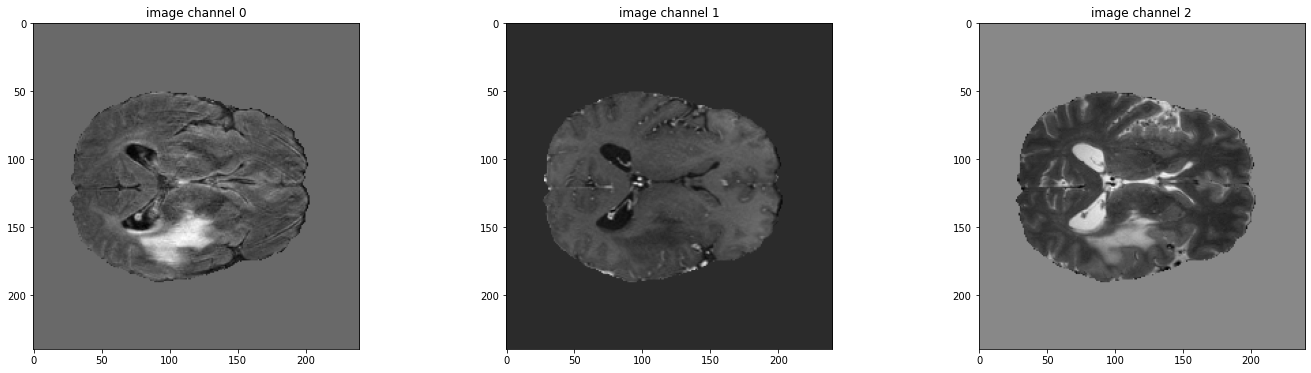

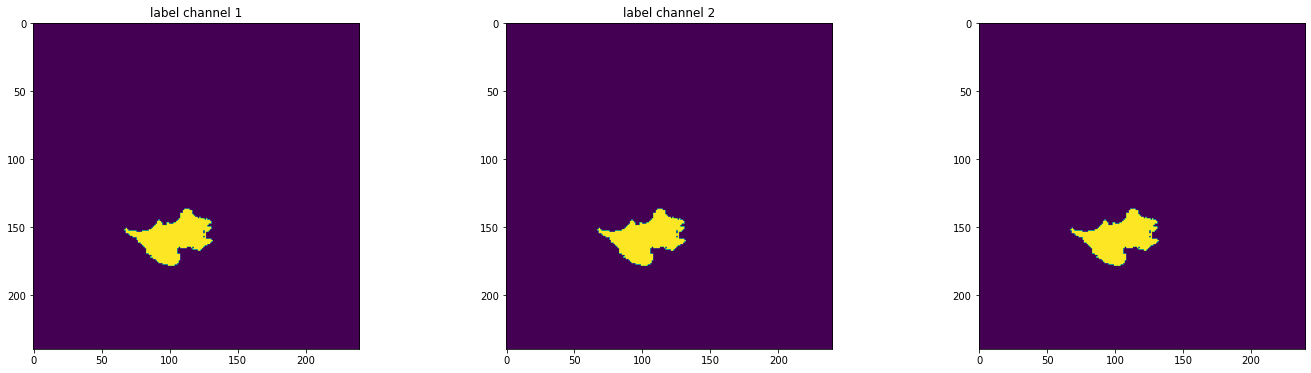

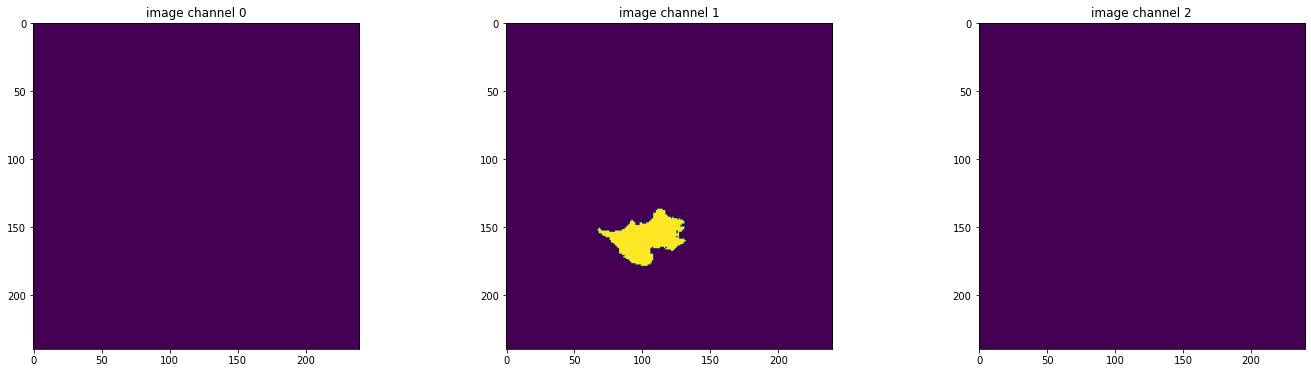

In [ ]:
plt.figure("image", (24, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(training_set[0]["image"][tio.DATA][i, :, :, 70].detach().cpu(), cmap="gray")
plt.show()
plt.figure("image", (24, 6))
for i in range(3):
  plt.title(f"label channel {i}")
  plt.subplot(1, 3, i + 1)
  plt.imshow(training_set[0]["label"][tio.DATA][0][ :, :, 70].detach().cpu())
plt.show()
plt.figure("image", (24, 6))
multi = toMultiChannel(training_set[0]["label"][tio.DATA])
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(multi[i, :, :, 70].detach().cpu())
plt.show()

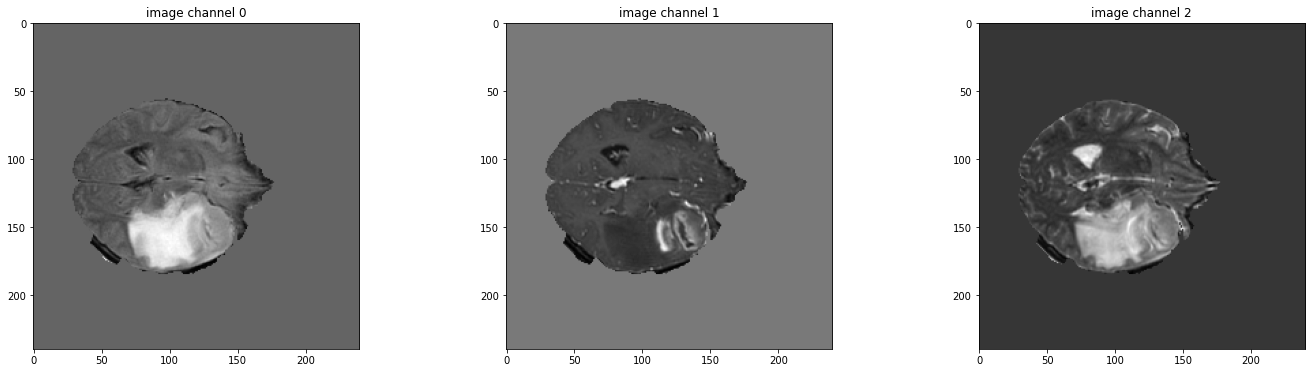

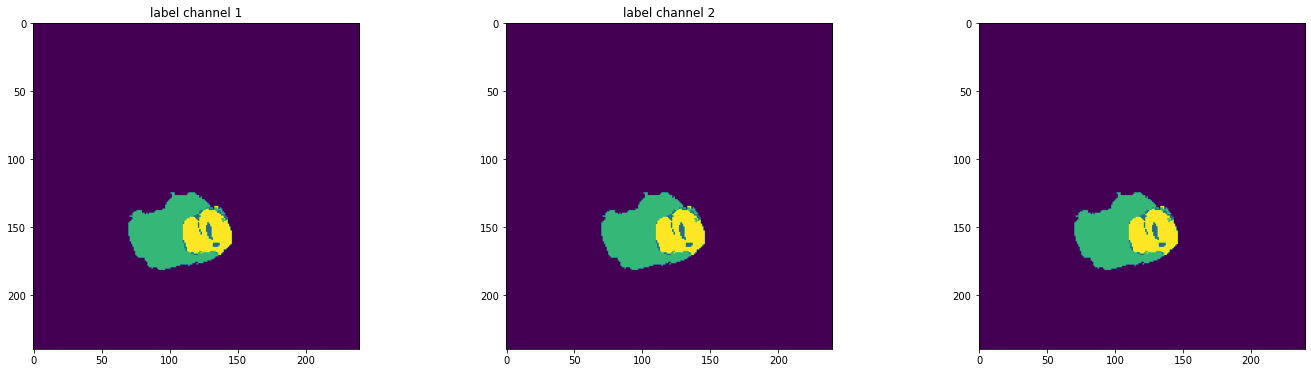

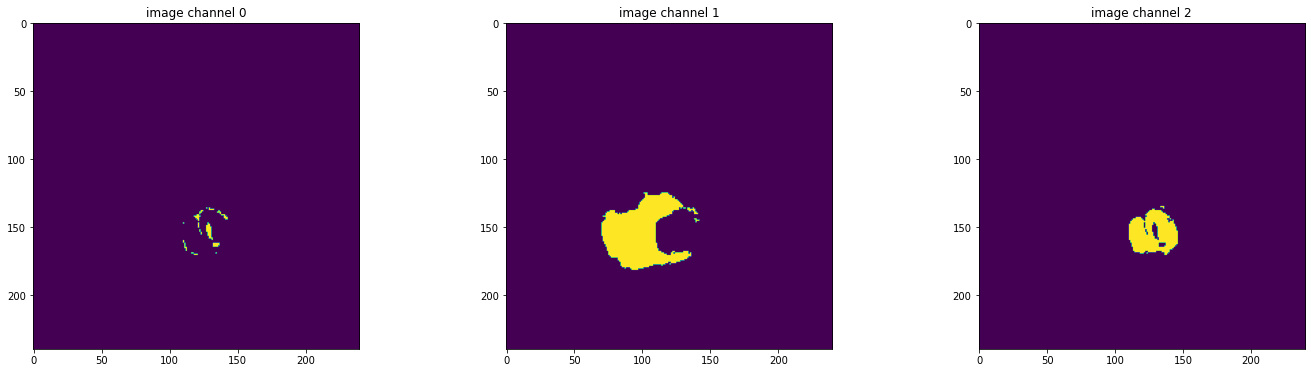

In [ ]:
plt.figure("image", (24, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(validation_set[0]["image"][tio.DATA][i, :, :, 70].detach().cpu(), cmap="gray")
plt.show()
plt.figure("image", (24, 6))
for i in range(3):
  plt.title(f"label channel {i}")
  plt.subplot(1, 3, i + 1)
  plt.imshow(validation_set[0]["label"][tio.DATA][0][ :, :, 70].detach().cpu())
plt.show()
plt.figure("image", (24, 6))
multi = toMultiChannel(validation_set[0]["label"][tio.DATA])
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(multi[i, :, :, 70].detach().cpu())
plt.show()

In [ ]:
training_batch_size = 1 #len(tio.GridSampler(train_subjects[0], patch_size=64))
validation_batch_size = 1 #2 * len(tio.GridSampler(val_subjects[0], patch_size=64))

x = validation_set[0]['image'][tio.DATA]
y = validation_set[0]['label'][tio.DATA]
# Dividir en patches
#sampler = tio.GridSampler(patch_size=(a,b,c), patch_overlap = (x,y,z))
subject = tio.Subject({'image': tio.ScalarImage(tensor=x), 'label': tio.LabelMap(tensor=y)})

#sampler = tio.GridSampler(subject, patch_size=64)
train_samples_per_volume = len(tio.GridSampler(subject, patch_size=64))
val_samples_per_volume = len(tio.GridSampler(subject, patch_size=64))
max_queue_length = len(tio.GridSampler(subject, patch_size=64))
sampler = tio.data.UniformSampler(patch_size=64) # Patches aleatorios del volumen
#sampler = tio.data.GridSampler(patch_size=64) # Divide el volumen entero en patches
#sampler = tio.data.WeightedSampler(64, 'sampling_map')
# Pondremos que haya 50% sin label y 50% con label (de cualquiera de las 3 clases, equiprobable)
#probabilities = {0:3, 1:1, 2:1 ,3:1} # Probabilidades de que cada patch tengo por centro 0 (no label), 1 (clase 1)...
#sampler = tio.data.LabelSampler(patch_size=64, label_name='label', label_probabilities=probabilities)

patches_training_set = tio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=train_samples_per_volume,
    sampler=sampler,
    num_workers=1,
    shuffle_subjects=True,
    shuffle_patches=True,
)

patches_validation_set = tio.Queue(
    subjects_dataset=validation_set,
    max_length=max_queue_length,
    samples_per_volume=val_samples_per_volume,
    sampler=sampler,
    num_workers=1,
    shuffle_subjects=False,
    shuffle_patches=False,
)

training_loader_patches = torch.utils.data.DataLoader(
    patches_training_set, batch_size=training_batch_size)

validation_loader_patches = torch.utils.data.DataLoader(
    patches_validation_set, batch_size=validation_batch_size)

## Transfer Learning

In [28]:
# Si False, modo finetuning y modifica todos los pesos. Con True, modo feature extraction y modifica el último
feature_extract = True 
names = ['final_block.conv.weight', 'final_block.conv.bias']#, 'final_block.adn.N.weight', 'final_block.adn.N.bias']
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for name,param in model.named_parameters():
            if name in names:
              param.requires_grad = True
            else:
              param.requires_grad = False

In [ ]:
# Cargar modelo pre-entrenado
from torch.nn import Conv3d
model = minet()
if not torch.cuda.is_available():
  model.load_state_dict(torch.load('/content/gdrive/MyDrive/Dice_Plateau_NoDA_12randombatch.pth', map_location='cpu'))
else:
  model.load_state_dict(torch.load('/content/gdrive/MyDrive/Dice_Plateau_NoDA_12randombatch.pth'))
set_parameter_requires_grad(model, feature_extract)
#model.final_block = simple_block(24, 4, 1) # Reiniciamos la última capa para entrenarla con la nueva muestra
model.to(device)

In [26]:
# enable cuDNN benchmark
if torch.cuda.is_available():
  torch.backends.cudnn.benchmark = True
  VAL_AMP = True
else:
  VAL_AMP = False
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(64, 64, 64), ## modificar???
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,  ##modificar?? 
        )
    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)

In [33]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(params_to_update, 1e-5, weight_decay=1e-5)

Params to learn:
	 final_block.conv.weight
	 final_block.conv.bias


In [ ]:
#optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5) # elies 1e-3

In [34]:
#loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True) # para multilabel
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=True, softmax=True) # para multiclass
#loss_function = DiceCELoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=True, softmax=True)
#optimizer = torch.optim.Adam(net.parameters(), 1e-4)
#optimizer = optim.SGD(net.parameters(), lr=0.1, weight_decay=1e-6)
#lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [93]:
model.eval()
for i,subject in enumerate(get_subjects()):
  if i < 1:
    continue
  elif i > 1:
    break
  pred_set = tio.SubjectsDataset(
    [subject], transform=validation_transform)
  sampler = tio.GridSampler(pred_set[0], patch_size=64)
  aggregator = tio.data.GridAggregator(sampler, overlap_mode='crop')
  aggregator2 = tio.data.GridAggregator(sampler, overlap_mode='average')
  loader = torch.utils.data.DataLoader(sampler, batch_size=1)
  with torch.no_grad():
      for val_data in loader:
          val_input = val_data["image"][tio.DATA].to(device)
          label = val_data["label"][tio.DATA].to(device)
          val_output = inference(val_input)
          aggregator2.add_batch(torch.unsqueeze([post_trans(i) for i in decollate_batch(val_output)][0], dim=0), val_data[tio.LOCATION])
          val_output = [torch.argmax(post_trans(i), dim=0, keepdim=True).to(torch.uint8) for i in decollate_batch(val_output)]
          aggregator.add_batch(torch.unsqueeze(val_output[0], dim=0), val_data[tio.LOCATION])
          val_output = [toMultiChannel(i) for i in val_output]
          label = [i for i in decollate_batch(label)]
          label = [toMultiChannel(i) for i in label]
          dice_metric(y_pred=val_output, y=label)
          dice_metric_batch(y_pred=val_output, y=label)

      metric_org = dice_metric.aggregate().item()
      metric_batch_org = dice_metric_batch.aggregate()

      dice_metric.reset()
      dice_metric_batch.reset()

  metric_tc, metric_wt, metric_et = metric_batch_org[0].item(), metric_batch_org[1].item(), metric_batch_org[2].item()

  print("Metric on original image spacing: ", metric_org)
  print(f"metric_tc: {metric_tc:.4f}")
  print(f"metric_wt: {metric_wt:.4f}")
  print(f"metric_et: {metric_et:.4f}")

Metric on original image spacing:  0.7205345034599304
metric_tc: 0.9676
metric_wt: 0.7036
metric_et: 0.9585


In [ ]:
nib1 = nb.load('/content/gdrive/MyDrive/Brats_2019/LGG/BraTS19_TCIA13_653_1/BraTS19_TCIA13_653_1_flair.nii.gz')
nib2 = nb.load('/content/gdrive/MyDrive/Brats_2019/LGG/BraTS19_TCIA13_653_1/BraTS19_TCIA13_653_1_t1ce.nii.gz')
nib3 = nb.load('/content/gdrive/MyDrive/Brats_2019/LGG/BraTS19_TCIA13_653_1/BraTS19_TCIA13_653_1_seg.nii.gz')

In [72]:
def toMultiChannel(data):
  # entra 1 canal, salen 3
  if len(data.shape) == 4:
    data = data[0].type(torch.uint8)
  else:
    data = data.type(torch.uint8)
  if data.get_device() == 0: # CUDA  
    zeros = torch.zeros(data.shape, dtype=torch.uint8).to(device)
    unos = torch.ones(data.shape, dtype=torch.uint8).to(device)
  else:
    zeros = torch.zeros(data.shape, dtype=torch.uint8)
    unos = torch.ones(data.shape, dtype=torch.uint8)
  result = []
  # merge label 2 and label 3 to construct TC, 1 y 3(transformado) en 2019
  result.append(torch.where(data==1, unos, zeros))
  # merge labels 1, 2 and 3 to construct WT
  result.append(torch.where(data==2, unos, zeros))
  # label 2 is ET, 3(transformado) en 2019
  result.append(torch.where(data==3, unos, zeros))
  resultado = torch.stack(result, axis=0)
  return resultado

In [96]:
# Chequear dice del output juntando patches con el label sin dividir en patches
output = aggregator.get_output_tensor()
print(output.size())
output_multi = [toMultiChannel(i) for i in output]
label = [i for i in decollate_batch(pred_set[0]['label'][tio.DATA])]
label = [toMultiChannel(i) for i in label]
dice_metric(y_pred=output_multi, y=label)
metric = dice_metric.aggregate().item()
print(metric)
dice_metric.reset()

output2 = aggregator2.get_output_tensor()
print(output2.size())
output2 = torch.argmax(output2, dim=0, keepdim=True).to(torch.uint8)
print(output2.size())
print(output2.unique())

output_multi = [toMultiChannel(i) for i in output2]
dice_metric(y_pred=output_multi, y=label)
metric = dice_metric.aggregate().item()
print(metric)
dice_metric.reset()
# aggregator.add_batch(torch.unsqueeze(val_output[0], dim=0), val_data[tio.LOCATION])

torch.Size([1, 240, 240, 155])
0.9339898228645325
torch.Size([4, 240, 240, 155])
torch.Size([1, 240, 240, 155])
tensor([0, 1, 2, 3], dtype=torch.uint8)
0.9367697834968567


In [87]:
output2[0].unique()

tensor([0], dtype=torch.uint8)

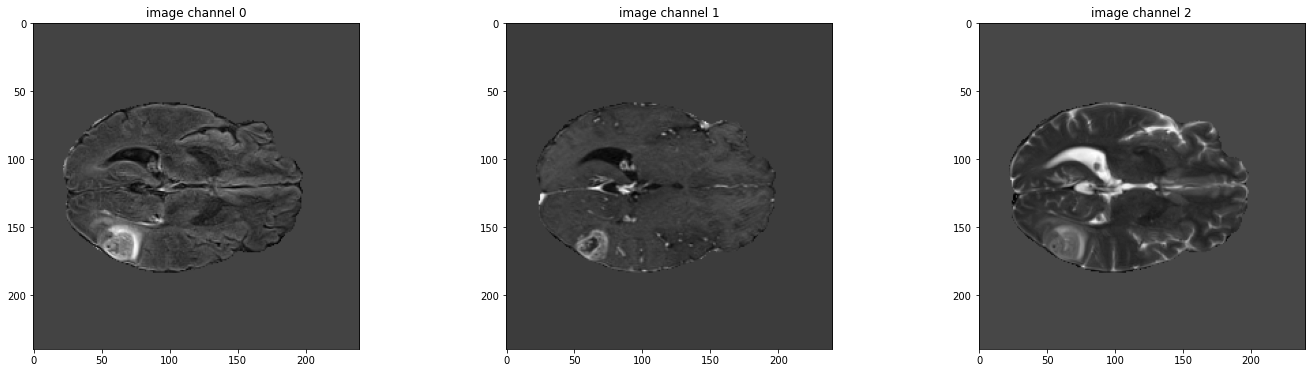

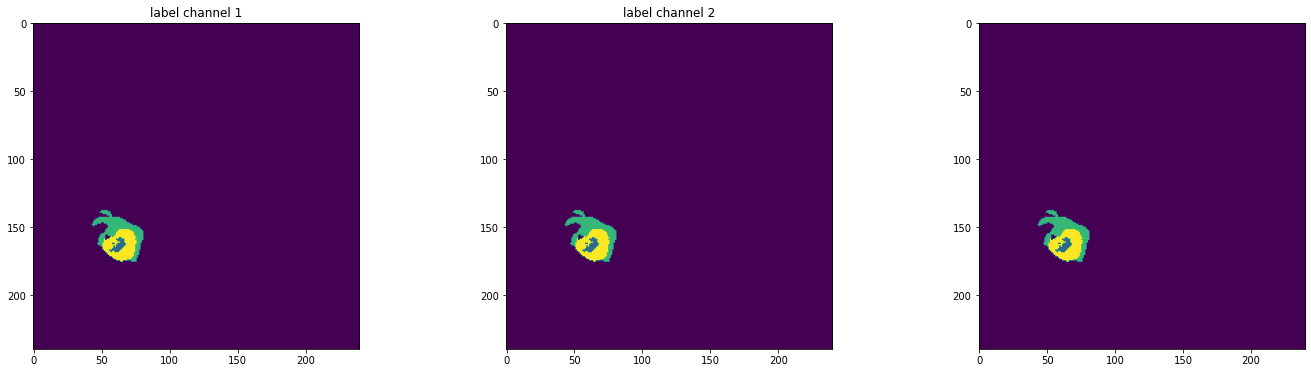

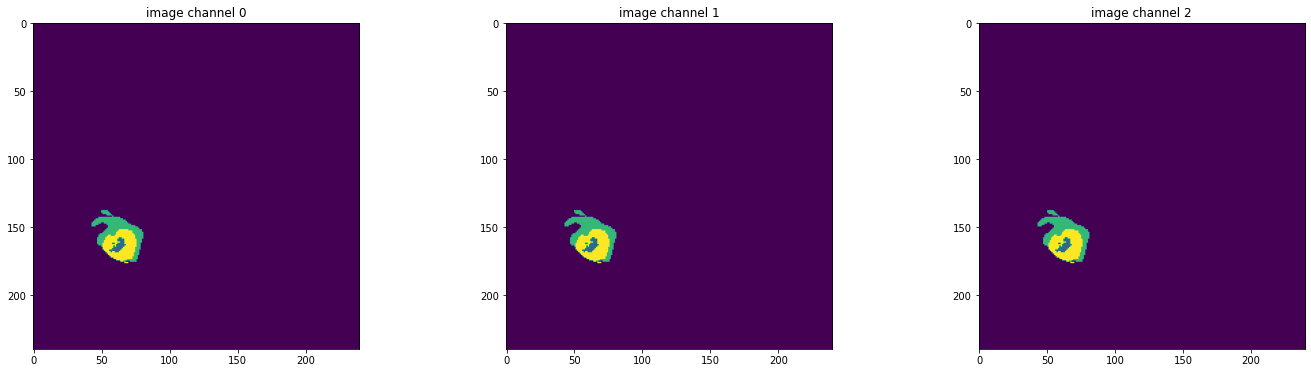

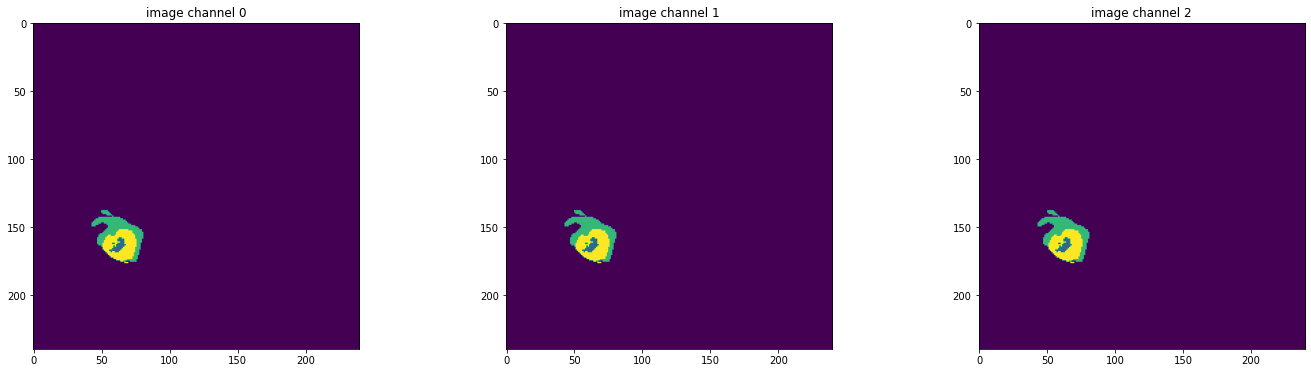

In [95]:
plt.figure("image", (24, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(pred_set[0]["image"][tio.DATA][i, :, :, 70].detach().cpu(), cmap="gray")
plt.show()
plt.figure("image", (24, 6))
for i in range(3):
  plt.title(f"label channel {i}")
  plt.subplot(1, 3, i + 1)
  plt.imshow(pred_set[0]["label"][tio.DATA][0][ :, :, 70].detach().cpu())
plt.show()
plt.figure("image", (24, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(output[0][ :, :, 70].detach().cpu())
plt.show()
plt.figure("image", (24, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(output[0][ :, :, 70].detach().cpu())
plt.show()

In [ ]:
path = Path("/content/sample_data")

In [ ]:
modelpath = list(path.glob('**/*.md'))[0]
modelname = modelpath.stem

In [ ]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []
print("\n---- Start Training ----")
# pred_set = tio.SubjectsDataset(
#     [subject], transform=validation_transform)
sampler = tio.GridSampler(pred_set[0], patch_size=64)
loader = torch.utils.data.DataLoader(sampler, batch_size=1)
probabilities = {0:1, 1:1, 2:1, 3:1}
#sampler_2 = tio.data.LabelSampler(patch_size=64, label_name='label', label_probabilities=probabilities)
sampler_2 = tio.UniformSampler(patch_size=64) # Patches aleatorios del volumen
patches_training_set = tio.Queue(
    subjects_dataset=pred_set,
    max_length=4,
    samples_per_volume=4,
    sampler=sampler_2,
    num_workers=1,
    shuffle_subjects=True,
    shuffle_patches=True,
)
loader_2 = torch.utils.data.DataLoader(patches_training_set, batch_size=4)
for epoch in range(10):
    model.train()
    epoch_loss = 0
    step = 0
    #for batch_data in train_loader:
    for batch_data in loader_2:
        step += 1
        inputs, labels = (
            batch_data["image"][tio.DATA].to(device),
            batch_data["label"][tio.DATA].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
    #lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    
    model.eval()
    with torch.no_grad():
        for val_data in loader:
            val_inputs, val_labels = (
                 val_data["image"][tio.DATA].to(device),
                 val_data["label"][tio.DATA].to(device),
             )
            val_outputs = inference(val_inputs)
            val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
            val_outputs = [toMultiChannel(torch.argmax(i, dim=0)) for i in val_outputs] # Para multiclass, volvemos a convertir en un canal de 4 valores
            val_labels = [i for i in decollate_batch(val_labels)]
            val_labels = [toMultiChannel(i) for i in val_labels]
            dice_metric(y_pred=val_outputs, y=val_labels)
            dice_metric_batch(y_pred=val_outputs, y=val_labels)
        metric = dice_metric.aggregate().item()
        metric_values.append(metric)
        metric_batch = dice_metric_batch.aggregate()
        metric_tc = metric_batch[0].item()
        metric_values_tc.append(metric_tc)
        metric_wt = metric_batch[1].item()
        metric_values_wt.append(metric_wt)
        metric_et = metric_batch[2].item()
        metric_values_et.append(metric_et)
        dice_metric.reset()
        dice_metric_batch.reset()

        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            best_metrics_epochs_and_time[0].append(best_metric)
            best_metrics_epochs_and_time[1].append(best_metric_epoch)
            torch.save(
               model.state_dict(),
               os.path.join(path, modelname + "_1.pth"),
            )
            #print("saved new best metric model")
    for param_group in optimizer.param_groups:
      current_lr = param_group['lr']        
    print(f"[Epoch {epoch + 1}] with LR: {current_lr:.5f} - Average train loss: {epoch_loss:.4f} - Test mean dice: {metric:.2f}%")
    print(f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}")


---- Start Training ----
[Epoch 1] with LR: 0.00001 - Average train loss: 0.5639 - Test mean dice: 0.79%
 tc: 0.2976 wt: 0.9146 et: 0.8408
[Epoch 2] with LR: 0.00001 - Average train loss: 0.4583 - Test mean dice: 0.79%
 tc: 0.2875 wt: 0.9108 et: 0.8428
[Epoch 3] with LR: 0.00001 - Average train loss: 0.7506 - Test mean dice: 0.76%
 tc: 0.2708 wt: 0.8884 et: 0.8418
[Epoch 4] with LR: 0.00001 - Average train loss: 0.6968 - Test mean dice: 0.76%
 tc: 0.2859 wt: 0.8862 et: 0.8423
[Epoch 5] with LR: 0.00001 - Average train loss: 0.7280 - Test mean dice: 0.75%
 tc: 0.2878 wt: 0.8749 et: 0.8428
[Epoch 6] with LR: 0.00001 - Average train loss: 0.7512 - Test mean dice: 0.74%
 tc: 0.2887 wt: 0.8674 et: 0.8438
[Epoch 7] with LR: 0.00001 - Average train loss: 0.5053 - Test mean dice: 0.75%
 tc: 0.2922 wt: 0.8732 et: 0.8452
[Epoch 8] with LR: 0.00001 - Average train loss: 0.7249 - Test mean dice: 0.74%
 tc: 0.3070 wt: 0.8628 et: 0.8452
[Epoch 9] with LR: 0.00001 - Average train loss: 0.7513 - Test